In [2]:
!pip install crr_labels epigenomic_dataset ucsc_genomes_downloader
!pip install pandas
!pip install Boruta
!pip install keras_mixed_sequence keras_bed_sequence
!pip install extra_keras_metrics
!pip install barplots
!pip install tqdm
!pip install minepy

     |████████████████████████████████| 279 kB 10.4 MB/s 
     |████████████████████████████████| 90 kB 12.1 MB/s 
  Created wheel for crr-labels: filename=crr_labels-1.1.1-py3-none-any.whl size=13909 sha256=f31f691277031196e3889a24bcd258bff1407d909dac00bf6f0dec78dcb77924
  Stored in directory: /root/.cache/pip/wheels/11/35/18/9f4c037100da0b7c44bbe85ed0d0e0520d71855f8d92c399c1
  Created wheel for epigenomic-dataset: filename=epigenomic_dataset-1.2.11-py3-none-any.whl size=16124 sha256=96cbdbcaec8ba2d55563451b6e4c1f60c563cb80bcc4a0b5e3b0e2af02de28fb
  Stored in directory: /root/.cache/pip/wheels/55/ae/00/711945f7eb139c3e7b5afd32628e468070b86698175d938b43
  Created wheel for encodeproject: filename=encodeproject-1.0.27-py3-none-any.whl size=9619 sha256=28076d1285aac59f2d850acca6ba2b8efefc427eaa28d14c656e28f31b7b3bd2
  Stored in directory: /root/.cache/pip/wheels/74/03/63/a272266e6c9c3d5ce2ccf1088508c952e91b0101650730ce44
  Created wheel for notipy-me: filename=notipy_me-1.3.23-py3-none-a

# Predizione di Regioni Regolatorie Attive nella cell line A549 mediante l’utilizzo di metodi di Deep Learning

In [3]:
from typing import Dict, List, Tuple, Optional
from cache_decorator import Cache
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.colors import ListedColormap, LogNorm
from multiprocessing import cpu_count, Pool
import matplotlib.pyplot as plt
from epigenomic_dataset.utils import get_cell_lines

Cell Line disponibili nella libreria epigenomic dataset:

In [4]:
from epigenomic_dataset.utils import get_cell_lines
get_cell_lines()

['A549', 'GM12878', 'H1', 'HEK293', 'HepG2', 'K562', 'MCF-7']

**Retrieval ENCODE epigenomic data [Promoters] -> Cell Line A549**

In [5]:
from epigenomic_dataset import load_epigenomes

X, y = load_epigenomes(
    cell_line = "A549",
    dataset = "fantom",
    region = "promoters",
    window_size = 256,
    root = "datasets"
)

**Calcolo il ratio tra le feature e gli esempi**

In [6]:
X.shape[0] / X.shape[1]

2080.8541666666665

I dati in questione hanno più esempi che feature

**Detection di valori nulli**

In [7]:
print("\n".join((
    f"Nan values report for A549 promoters data:",
    f"In the document there are {X.isna().values.sum()} NaN values out of {X.values.size} values.",
    f"The sample (row) with most values has {X.isna().sum(axis=1).max()} NaN values out of {X.shape[1]} values.",
    f"The feature (column) with most values has {X.isna().sum().max()} NaN values out of {X.shape[0]} values."
)))

Nan values report for A549 promoters data:
In the document there are 372 NaN values out of 4794288 values.
The sample (row) with most values has 2 NaN values out of 48 values.
The feature (column) with most values has 189 NaN values out of 99881 values.


**Data Imputation**

Useremo la neighbours imputation che sfrutta l’algoritmo k-Nearest Neighbours per riempire i valori mancanti. Di default come metrica è utilizzata la distanza euclidea dal valore mancante ai suoi vicini, viene poi fatta la media dei valori vicini oppure viene pesato il valore in base alla distanza di ogni vicino.

In [8]:
from sklearn.impute import KNNImputer

def knn_imputation(df:pd.DataFrame, neighbours:int=5)->pd.DataFrame:
    """Return provided dataframe with NaN imputed using knn.
    
    Parameters
    --------------------
    df:pd.DataFrame,
        The dataframe to impute.
    neighbours:int=5,
        The number of neighbours to consider.
        
    Returns
    --------------------
    The dataframe with the NaN values imputed.
    """
    return pd.DataFrame(
        KNNImputer(n_neighbors=neighbours).fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [9]:
X = knn_imputation(X)

**Drop Constant Feature**

A volte vi sono feature con gli stessi valori costanti, dato che non aggiungono informazioni, possiamo dropparle.

In [10]:
def drop_constant_features(df:pd.DataFrame)->pd.DataFrame:
    """Return DataFrame without constant features."""
    return df.loc[:, (df != df.iloc[0]).any()]

In [11]:
drop_constant_features(X).shape != X.shape

False

Non sono presenti costant feature nel dataset

**Z-scoring**

In [12]:
from sklearn.preprocessing import RobustScaler

def robust_zscoring(df:pd.DataFrame)->pd.DataFrame:
    """Return given dataframe scaled using robust z-scoring."""
    return pd.DataFrame(
        RobustScaler().fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [13]:
X = robust_zscoring(X)

**Correlation con l'output - Linear correlations: The Pearson correlation coefficient**

In [14]:
p_value_threshold = 0.01
correlation_threshold = 0.05

In [15]:
from scipy.stats import pearsonr

for feature in tqdm(X.columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    correlation, p_value = pearsonr(X[feature].values.flatten(), y.values.flatten())
    if p_value > p_value_threshold:
        print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")

Running Pearson test:   0%|          | 0/48 [00:00<?, ?it/s]

The feature ZC3H11A does not correlate in a statistically significant manner with the output.
The feature PRDM1 does not correlate in a statistically significant manner with the output.
The feature EHMT2 does not correlate in a statistically significant manner with the output.
The feature FOSB does not correlate in a statistically significant manner with the output.
The feature SREBF2 does not correlate in a statistically significant manner with the output.
The feature FOXF2 does not correlate in a statistically significant manner with the output.
The feature RFX5 does not correlate in a statistically significant manner with the output.
The feature CHD4 does not correlate in a statistically significant manner with the output.


In [16]:
from scipy.stats import spearmanr

for feature in tqdm(X.columns, desc=f"Running Spearman test", dynamic_ncols=True, leave=False):
    correlation, p_value = spearmanr(X[feature].values.flatten(), y.values.flatten())
    if p_value > p_value_threshold:
        print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")

Running Spearman test:   0%|          | 0/48 [00:00<?, ?it/s]

In [17]:
from minepy import MINE

for feature in tqdm(("ZC3H11A", "FOXF2"), desc=f"Running MINE test", dynamic_ncols=True, leave=False):
    mine = MINE()
    mine.compute_score(X[feature].values.ravel(), y.values.ravel())
    score = mine.mic()
    if score < correlation_threshold:
        print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")

Running MINE test:   0%|          | 0/2 [00:00<?, ?it/s]

The feature ZC3H11A does not correlate in a statistically significant manner with the output.
The feature FOXF2 does not correlate in a statistically significant manner with the output.


**Correlation tra Features**

In [18]:
from scipy.stats import pearsonr

def compute_pearson(
    X:pd.DataFrame,
    feature_left: str,
    feature_right: str,
    cell_line: str,
    region: str
) -> Dict:
    """Returns Pearson correlation.
    
    Parameters
    ----------------------
    X:pd.DataFrame,
        The epigenomic data.
    feature_left: str,
        The left features to compute pearson for.
    feature_right: str,
        The right features to compute pearson for.
    cell_line: str,
        The cell line.
    region: str,
        The cis-regulatory region of interest.
    """
    correlation, p_value = pearsonr(
        X[feature_left].values.flatten(),
        X[feature_right].values.flatten(),
    )
    return dict(
        correlation=correlation,
        p_value=p_value
    )

for feature_left in tqdm(X.columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    for feature_right in X.columns:
        if feature_left >= feature_right:
            continue
        pearson_result = compute_pearson(
            X,
            feature_left,
            feature_right,
            cell_line="A549",
            region="promoters"
        )
        if pearson_result["p_value"] < p_value_threshold and np.abs(pearson_result["correlation"]) > 0.95:
            correlation = pearson_result["correlation"]
            print(f"The feature {feature_left} is highly correlated with {feature_right} ({correlation}).")
            

Running Pearson test:   0%|          | 0/48 [00:00<?, ?it/s]

Nessuna Feature altamente correlata ad un'altra

**Features selection con Boruta e Random Forests**

In [19]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from boruta import BorutaPy
from multiprocessing import cpu_count


def execute_boruta_feature_selection(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    holdout_number: int,
    regression: bool,
    task_name: str,
    max_iter: int = 100
):
    """Returns tuple with list of kept features and list of discared features.
    
    Parameters
    --------------------------
    X_train: pd.DataFrame,
        The data reserved for the input of the training of the Boruta model.
    y_train: np.ndarray,
        The data reserved for the output of the training of the Boruta model.
    holdout_number: int,
        The current holdout number.
    regression: bool,
        Whether the task is a binary classification one (False) or a regression one (True).
    task_name: str,
        The name of the task.
    max_iter: int = 100,
        Number of iterations to run Boruta for.
    """
    # According to the requested task we build either a random forest regressor
    # or a random forest classifier.
    if regression:
        model = RandomForestRegressor(n_jobs=cpu_count(), max_depth=5)
    else:
        model = RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced_subsample', max_depth=5)
    
    # Create the Boruta model
    boruta_selector = BorutaPy(
        # Defining the model that Boruta should use.
        model,
        # We leave the number of estimators to be decided by Boruta
        n_estimators='auto',
        verbose=False,
        alpha=0.05, # p_value
        # In practice one would run at least 100-200 times,
        # until all tentative features are exausted.
        max_iter=max_iter, 
        random_state=42,
    )
    # Fit the Boruta model
    boruta_selector.fit(X_train.values, y_train)
    
    # Get the kept features and discarded features
    kept_features = list(X_train.columns[boruta_selector.support_])
    discarded_features = list(X_train.columns[~boruta_selector.support_])
    
    # Filter out the unused featured.
    return kept_features, discarded_features

---------------------------------------------------------------------------------------------------------------------------------------------

**Retrieving della sequenza genomica**

In [20]:
from ucsc_genomes_downloader import Genome

genome = Genome("hg38")

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

In [21]:
genome

Human, Homo sapiens, hg38, 2013-12-07, 25 chromosomes

In [22]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

In [23]:
to_bed(y)

,chrom,chromStart,chromEnd,strand
0,chr1,628964,629220,+
1,chr1,629013,629269,+
2,chr1,629642,629898,+
3,chr1,629847,630103,+
4,chr1,629905,630161,+
...,...,...,...,...
99876,chrX,154441877,154442133,+
99877,chrX,154584927,154585183,+
99878,chrY,1452882,1453138,-
99879,chrY,2500959,2501215,-


In [24]:
genome.bed_to_sequence(to_bed(y))

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


array(['AAATGGTCATCCATCCTTTGGCCCCAATACCTAAACTAAGGTCTATGAACAATAAGATGATTTTCTTCAGTGGGACTTTTTTGTTTAATATATTAGATTTGACCTTCAGCAAGGTCAAAGGGAGTCCGAACTAGTCTCAGGCTTCAACATCGAATACGCCGCAGGCCCCTTCGCCCTATTCTTCATAGCCGAATACACAAACATTATTATAATAAACACCCTCACCACTACAATCTTCCTAGGAACAACATATAAC',
       'CAATAAGATGATTTTCTTCAGTGGGACTTTTTTGTTTAATATATTAGATTTGACCTTCAGCAAGGTCAAAGGGAGTCCGAACTAGTCTCAGGCTTCAACATCGAATACGCCGCAGGCCCCTTCGCCCTATTCTTCATAGCCGAATACACAAACATTATTATAATAAACACCCTCACCACTACAATCTTCCTAGGAACAACATATAACGCACTCTCCCCTGAACTCTACACAACATATTTTGTCACCAAGACCCTAC',
       'AATCCCCTGGCCCAACCCGTCATCTACTCTACCATCTTTGCAGGCACACTCATCACAGCGCTAAGCTCGCACTGATTTTTTACCTGAGTAGGCCTAGAAATAAACATGCTAGCTTTTATTCCAGTTCTAACCAAAAAAATAAACCCTCGTTCCACAGAAGCTGCCATCAAGTATTTCCTCACGCAAGCAACCGCATCCATAATCCTTCTAATAGCTATCCTCTTCAACAATATACTCTCCGGACAATGAACCATAA',
       ...,
       'AGATTTATAACATATATGATATAATCATGGGGGGGGTGAATAATTGAGACTTTATTCTTATAGAATTGTATTTTTATTTATTCTTATAGAATTGTATTTGACTTATATTCCTGACAATTCTTTTATAGAGTTATATTTGAATTGTATTCTTGCCAGGTGTCTTACTGAATTCTATTTGA

In [25]:
from keras_bed_sequence import BedSequence

np.array(BedSequence(
    genome,
    bed=to_bed(y),
    batch_size=1
))

array([[[[0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         ...,
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.]]],


       [[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.]]],


       [[[0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.]]],


       ...,


       [[[0., 0., 0., 1.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.]]],


       [[[0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.]]],


       [[[0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
     

**Features visualization con PCA**

In [26]:
from sklearn.decomposition import PCA

#Metodo che ritorna il plot della decomposizione PCA della cella data in input
def get_pca_decomposition(
    X: pd.DataFrame,
    data_type: str,
    region: str,
    cell_line: str,
    metric: str,
    **kwargs
) -> pd.DataFrame:
    return pd.DataFrame(
        PCA(n_components=2).fit_transform(X.values),
        index=X.index
    )

In [27]:
#Metodo che definisce lo scatter plot
def scatter_with_heatmap(
    decomposition: pd.DataFrame,
    scores: np.ndarray,
    figure: Figure,
    ax: Axes
):
    scatter = ax.scatter(
        *decomposition.values.T,
        c=scores,
        cmap=plt.cm.get_cmap('RdYlBu'),
        norm=LogNorm(),
        s=3
    )
    color_bar = figure.colorbar(scatter, ax=ax)

Main Loop

Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

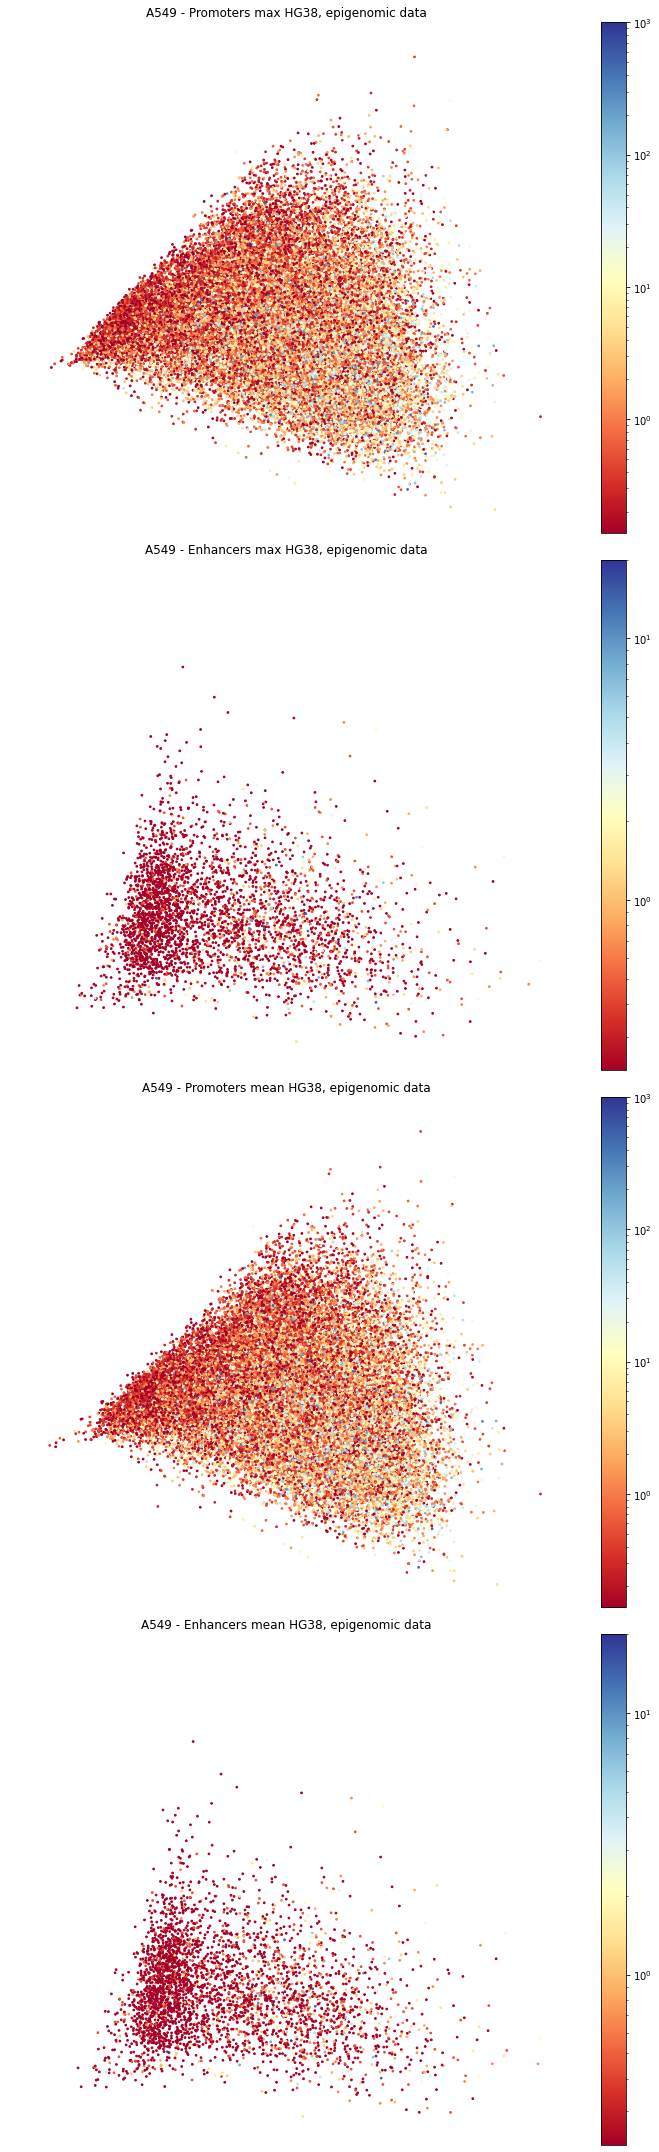

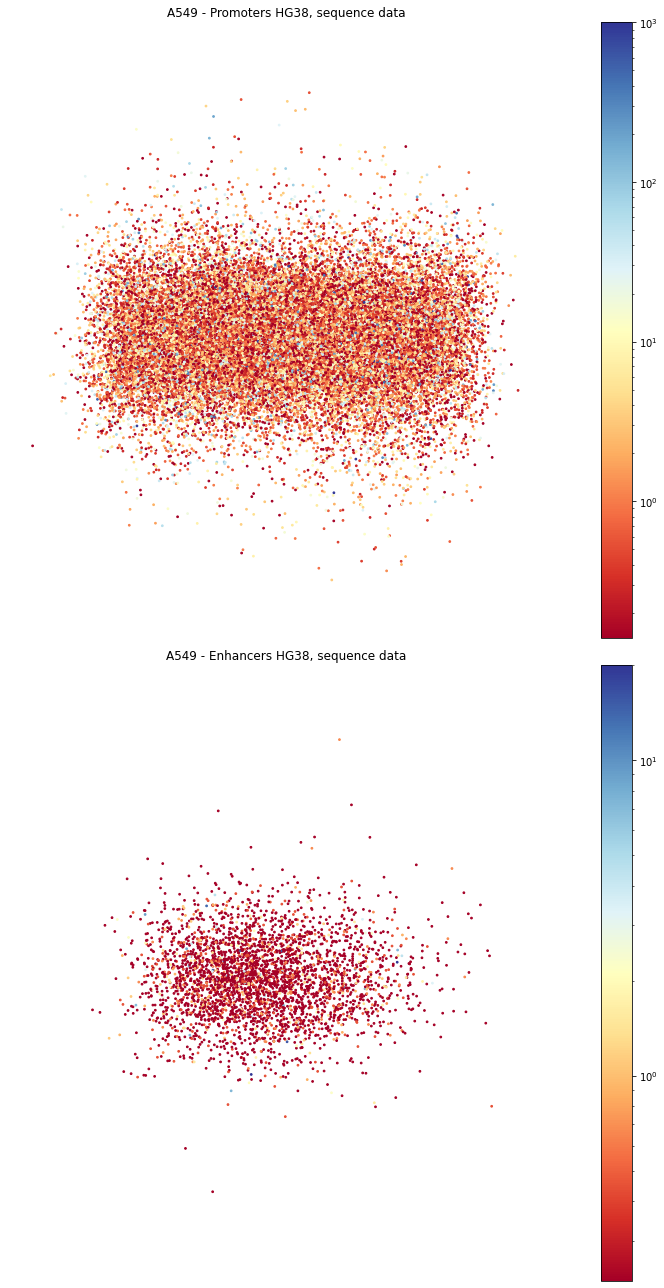

In [28]:
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from keras_bed_sequence import BedSequence

epigenomic_fig, epigenomic_axes = plt.subplots(
    nrows=4,
    ncols=1,
    figsize=(10*1, 30),
    squeeze=False
)

sequence_fig, sequence_axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10*1, 18),
    squeeze=False
)

for k, metric in enumerate(tqdm(("max", "mean"), desc="Metrics", leave=False)):
      for j, ((epigenomic, scores), region, clip_value) in enumerate(tqdm((
          (active_promoters_vs_inactive_promoters(cell_line="A549", metric=metric), "Promoters", 1000),
          (active_enhancers_vs_inactive_enhancers(cell_line="A549", metric=metric), "Enhancers", 20)
      ), desc="Task", leave=False)):
          imputed_epigenomic = pd.DataFrame(
              MinMaxScaler().fit_transform(
                  KNNImputer().fit_transform(epigenomic)
              ),
              columns=epigenomic.columns,
              index=epigenomic.index
          )
          decomposed_epigenomic = get_pca_decomposition(
              imputed_epigenomic,
              "epigenomic",
              region,
              "A549",
              metric
          )
          scores[scores>clip_value] = clip_value
          scatter_with_heatmap(
              decomposition=decomposed_epigenomic,
              scores=scores.values,
              figure=epigenomic_fig,
              ax=epigenomic_axes[j + 2*k + 0*4][0]
          )
          epigenomic_axes[j + 2*k + 0*4][0].set_title(f"A549 - {region} {metric} HG38, epigenomic data")
          epigenomic_axes[j + 2*k + 0*4][0].set_axis_off()
                
          if k==0:
              sequence = pd.DataFrame(
                  np.array(BedSequence(
                      genome,
                      bed=to_bed(scores),
                      batch_size=1
                  )).reshape(-1, 4*256),
                  index=scores.index
              )
              decomposed_sequence = get_pca_decomposition(
                  sequence,
                  "sequence",
                  region,
                  "A549",
                  metric="None",
              )
              scatter_with_heatmap(
                  decomposition=decomposed_sequence,
                  scores=scores.values,
                  figure=sequence_fig,
                  ax=sequence_axes[j + 0*2][0]
              )
              sequence_axes[j + 0*2][0].set_title(f"A549 - {region} HG38, sequence data")
              sequence_axes[j + 0*2][0].set_axis_off()

epigenomic_fig.tight_layout()
sequence_fig.tight_layout()
plt.show()

---------------------------------------------------------------------------------------------------------------------------------

**Training, Testing and Evaluation**

In [29]:
from typing import Tuple
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from extra_keras_metrics import get_complete_binary_metrics

**Feed Forward Neural Network**

In [33]:
def build_binary_classification_ffnn(
    input_shape: int
)->Tuple[Model, Layer, Layer]:
    """Returns Feed-Forward Neural Network model for binary classification.
    
    Parameters
    -----------------------
    input_shape: int,
        Number of features in the input layer.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    hidden = Dense(64, activation="relu")(input_epigenomic_data)

    hidden = Dense(32, activation="relu",)(hidden)
    hidden = Dropout(rate=0.2)(hidden)
    hidden = Dense(16, activation="relu",)(hidden)

    for _ in range(2):
        hidden = Dense(8, activation="relu",)(hidden)
        hidden = Dropout(rate=0.4)(hidden)

    last_hidden_ffnn = hidden
    output_ffnn = Dense(1, activation="sigmoid")(input_epigenomic_data)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="FeedForward_NN"
    )

    ffnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return ffnn, input_epigenomic_data, last_hidden_ffnn

**Convolutional Neural Network**

In [35]:
def build_binary_classification_cnn(
    window_size: int
)->Tuple[Model, Layer, Layer]:
    """Returns Convolutional Neural Network model for binary classification.
    
    Parameters
    -----------------------
    window_size: int,
        Size of the input genomic window.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_sequence_data = Input(shape=(window_size, 4), name="sequence_data")
    hidden = Conv1D(64, kernel_size=6, activation="relu")(input_sequence_data)

    hidden = Conv1D(32, kernel_size=4, activation="relu",)(hidden)
    hidden = MaxPool1D(pool_size=2)(hidden)
    hidden = Dropout(rate=0.20)(hidden)

    hidden = Conv1D(16, kernel_size=4, activation="relu",)(hidden)
    hidden = MaxPool1D(pool_size=2)(hidden)
    hidden = Dropout(rate=0.30)(hidden)

    hidden = Conv1D(16, kernel_size=4, activation="relu",)(hidden)
    hidden = MaxPool1D(pool_size=2)(hidden)
    hidden = Dropout(rate=0.40)(hidden)
        
    hidden = GlobalAveragePooling1D()(hidden)
    last_hidden_cnn = Dense(64, activation="relu")(hidden)
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="Convolutional_NN"
    )

    cnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return cnn, input_sequence_data, last_hidden_cnn

**Multi Modal Neural Network**

In [36]:
def build_binary_classification_mmnn(
    input_shape: Optional[int] = None,
    window_size: Optional[int] = None,
    input_epigenomic_data: Optional[Layer] = None,
    input_sequence_data: Optional[Layer] = None,
    last_hidden_ffnn: Optional[Layer] = None,
    last_hidden_cnn: Optional[Layer] = None,
):
    """Returns Multi-Modal Neural Network model for binary classification.
    
    Implementative details
    -----------------------
    If the input shape / window size is not provided and the input layers and 
    the feature selection layers are provided, then the network will start
    to train from those layers (which are expected to be pre-trained).
    Conversely, it will create the submodules for the epigenomic and sequence
    data ex-novo.
    
    Parameters
    -----------------------
    input_shape: Optional[int] = None,
        Number of features in the input layer.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    window_size: int,
        Size of the input genomic window.
        Either the window size or the input and output layers of the CNN
        must be provided.
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
    last_hidden_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.    
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
        
    Raises
    -----------------------
    ValueError,
        If the input shape is not provided and the input layer and feature selection
        layer of the FFNN are not provided.
    ValueError,
        If the window size is not provided and the input layer and feature selection
        layer of the CNN are not provided.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    if input_shape is None and (last_hidden_ffnn is None or input_epigenomic_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input epigenomic "
            "layer must be provided."
        )
    if window_size is None and (last_hidden_cnn is None or input_sequence_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input sequence "
            "layer must be provided."
        )
        
    if input_shape is not None:
        _, input_epigenomic_data, last_hidden_ffnn = build_binary_classification_ffnn(input_shape)
        
    if window_size is not None:
        _, input_sequence_data, last_hidden_cnn = build_binary_classification_cnn(window_size)
        
    concatenation_layer = Concatenate()([
        last_hidden_ffnn,
        last_hidden_cnn
    ])

    last_hidden_mmnn = Dense(64, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="BoostedMMNN" if input_shape is None else "Multimodal_NN"
    )

    mmnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return mmnn

**Creazione della training sequences**

In [37]:
from keras_mixed_sequence import MixedSequence, VectorSequence
from keras_bed_sequence import BedSequence

def get_cnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a CNN model on genomic sequences.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a CNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )


def get_ffnn_sequence(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a FFNN model on epigenomic data.
    
    Parameters
    -------------------------
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a FFNN.
    """
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )


def get_mmnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a MMNN model on both genomic sequences and epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a MMNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            ),
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

def train_model(
    model: Model,
    model_name: str,
    task: str,
    cell_line: str,
    training_sequence: MixedSequence,
    test_sequence: MixedSequence,
    holdout_number: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Returns training history and model evaluations.
    
    Parameters
    ---------------------
    model: Model,
        The model to train.
    model_name: str,
        The model name.
    task: str,
        The name of the task.
    cell_line: str,
        Name of the considered cell line.
    training_sequence: MixedSequence,
        The training sequence.
    test_sequence: MixedSequence,
        The test sequence.
    holdout_number: int,
        The number of the current holdout.
        
    Returns
    ----------------------
    Tuple with training history dataframe and model evaluations dataframe.
    """
    history = pd.DataFrame(model.fit(
        train_sequence,
        validation_data=test_sequence,
        epochs=1000,
        verbose=False,
        callbacks=[
            EarlyStopping(
                "loss",
                min_delta=0.001,
                patience=2,
                mode="min"
            ),
            # TqdmCallback(verbose=1)
        ]
    ).history)
    
    train_evaluation = dict(zip(model.metrics_names, model.evaluate(train_sequence, verbose=False)))
    test_evaluation = dict(zip(model.metrics_names, model.evaluate(test_sequence, verbose=False)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

**Model evaluation**

Holdouts

In [39]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

#Semplice Holdout 80/20

holdouts_generator = StratifiedShuffleSplit(
    n_splits=10,
    test_size=0.2
)

**Evaluation of the models predictions - In order to evaluate the models predictions, we consider the Accuracy, AUPRC and AUROC metrics:**

In [40]:
from tqdm.auto import tqdm
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
from epigenomic_dataset.utils import normalize_epigenomic_data

# Lista per le performance dei modelli (training e test)
all_binary_classification_performance = []

training_histories = {}

window_size = 256
cell_line = "A549"

# Cicla sui task
for task, threshold in tqdm((
    (active_enhancers_vs_inactive_enhancers, 0),
    (active_promoters_vs_inactive_promoters, 1)
), desc="Tasks"):
    task_name = task.__name__
    X, y = task(
        binarize=True,
        cell_line=cell_line,
        window_size=window_size,
        min_active_tpm_value=threshold,
        max_inactive_tpm_value=threshold
    )
    training_histories[task_name] = []

    #CLEAN

    # Extract the bed coordinates from the epigenomic dataset
    bed = to_bed(X)
    # Get the number of features of this specific dataset
    number_of_features = X.shape[1]

    # Main loop, cicla sul numero di holdout definiti sopra
    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(holdouts_generator.split(X, y)),
        total=10,
        leave=False,
        desc="Computing holdouts"
    ):
        # prendo i dati di training e test
        train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
        train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
        train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]
        # nromalizzo i dati epigenomici
        train_X, test_X = normalize_epigenomic_data(train_X, test_X)
        
        # Flatten dei valori di output
        train_y = train_y.values.flatten()
        test_y = test_y.values.flatten()
        
        ffnn, input_epigenomic_data, last_hidden_ffnn = build_binary_classification_ffnn(number_of_features)
        cnn, input_sequence_data, last_hidden_cnn = build_binary_classification_cnn(window_size)
        mmnn = build_binary_classification_mmnn(number_of_features, window_size)

        for model, train_sequence, test_sequence in tqdm(
            (
                (ffnn, get_ffnn_sequence(train_X, train_y), get_ffnn_sequence(test_X, test_y)),
                (cnn, get_cnn_sequence(genome, train_bed, train_y), get_cnn_sequence(genome, test_bed, test_y)),
                (mmnn, get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, test_bed, test_X, test_y))
            ),
            desc="Training models",
            leave=False
        ):

            # -> AGGIUNGERE FEATURE SELECTION CON BORUTA
            #execute_boruta_feature_selection(X, y, 10, False, task_name)
            
            # Performance del modello
            history, performance = train_model(
                model,
                model.name,
                task_name,
                cell_line,
                train_sequence,
                test_sequence,
                holdout_number
            )
            training_histories[task_name].append(history)

            # Performance aggiunte alla lista di tutte le performance delle classificazioni binarie
            all_binary_classification_performance.append(performance)
        
# Converto da liste a DataFrame
all_binary_classification_performance = pd.concat(all_binary_classification_performance)


Tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Computing holdouts:   0%|          | 0/10 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Computing holdouts:   0%|          | 0/10 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

In [41]:
all_binary_classification_performance

,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,fall_out,mcc,tp/t,fp/t,tn/t,fn/t,negative_predictive_value,false_discovery_rate,false_omission_rate,prevalence_threshold,threat_score,fowlkes_mallows_index,informedness,markedness,LR_pos,LR_neg,DOR,run_type,model_name,task,holdout_number
0,0.211014,0.942996,0.002776,0.400000,0.619504,0.141772,0.005513,0.501262,0.999749,0.997224,0.000251,0.029435,0.000158,0.000237,0.942838,0.056767,0.943211,0.600000,0.056789,0.231300,0.002764,0.501262,0.033322,0.343211,11.040253,0.997475,1.005062,train,FeedForward_NN,active_enhancers_vs_inactive_enhancers,0
1,0.210491,0.942877,0.001387,0.250000,0.630141,0.138334,0.002759,0.500568,0.999749,0.998613,0.000251,0.014808,0.000079,0.000237,0.942798,0.056886,0.943097,0.750000,0.056904,0.298567,0.001381,0.500568,0.018621,0.193097,5.516068,0.998864,1.002274,test,FeedForward_NN,active_enhancers_vs_inactive_enhancers,0
0,0.231610,0.943075,0.000000,0.000000,0.600755,0.104397,0.000000,0.500000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.943075,0.056925,0.943075,0.000000,0.056925,0.000000,0.000000,0.500000,0.000000,-0.056925,0.000000,1.000000,1.000000,train,Convolutional_NN,active_enhancers_vs_inactive_enhancers,0
1,0.232100,0.943035,0.000000,0.000000,0.586680,0.102795,0.000000,0.500000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.943035,0.056965,0.943035,0.000000,0.056965,0.000000,0.000000,0.500000,0.000000,-0.056965,0.000000,1.000000,1.000000,test,Convolutional_NN,active_enhancers_vs_inactive_enhancers,0
0,0.194696,0.943154,0.001388,1.000000,0.771308,0.260091,0.002772,0.500694,1.000000,0.998612,0.000000,0.036180,0.000079,0.000000,0.943075,0.056846,0.943150,0.000000,0.056851,0.000000,0.001388,0.500694,0.037255,0.943150,13879.250000,0.998612,1.002780,train,Multimodal_NN,active_enhancers_vs_inactive_enhancers,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.377339,0.813335,0.331207,0.573736,0.848867,0.531373,0.419972,0.634065,0.936922,0.668793,0.063078,0.335205,0.067578,0.050208,0.745758,0.136457,0.845325,0.426264,0.154675,0.303817,0.265800,0.634065,0.435919,0.419060,5.250763,0.713819,1.732723,test,FeedForward_NN,active_promoters_vs_inactive_promoters,9
0,0.441766,0.795993,0.000000,0.000000,0.751456,0.376935,0.000000,0.500000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.795993,0.204007,0.795993,0.000000,0.204007,0.000000,0.000000,0.500000,0.000000,-0.204007,0.000000,1.000000,1.000000,train,Convolutional_NN,active_promoters_vs_inactive_promoters,9
1,0.447151,0.795965,0.000000,0.000000,0.740580,0.370280,0.000000,0.500000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.795965,0.204035,0.795965,0.000000,0.204035,0.000000,0.000000,0.500000,0.000000,-0.204035,0.000000,1.000000,1.000000,test,Convolutional_NN,active_promoters_vs_inactive_promoters,9
0,0.345195,0.825128,0.553463,0.574065,0.871008,0.553129,0.563576,0.724108,0.894753,0.446537,0.105247,0.454397,0.112910,0.083776,0.712217,0.091097,0.886599,0.425935,0.113401,0.303657,0.392346,0.724108,0.563670,0.460663,5.258720,0.499061,2.624609,train,Multimodal_NN,active_promoters_vs_inactive_promoters,9


Rendering barplots:   0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/barplots/utils/get_axes.py:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  dpi=dpi


((<Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure size 2400x680 with 2 Axes>,
  <Figure si

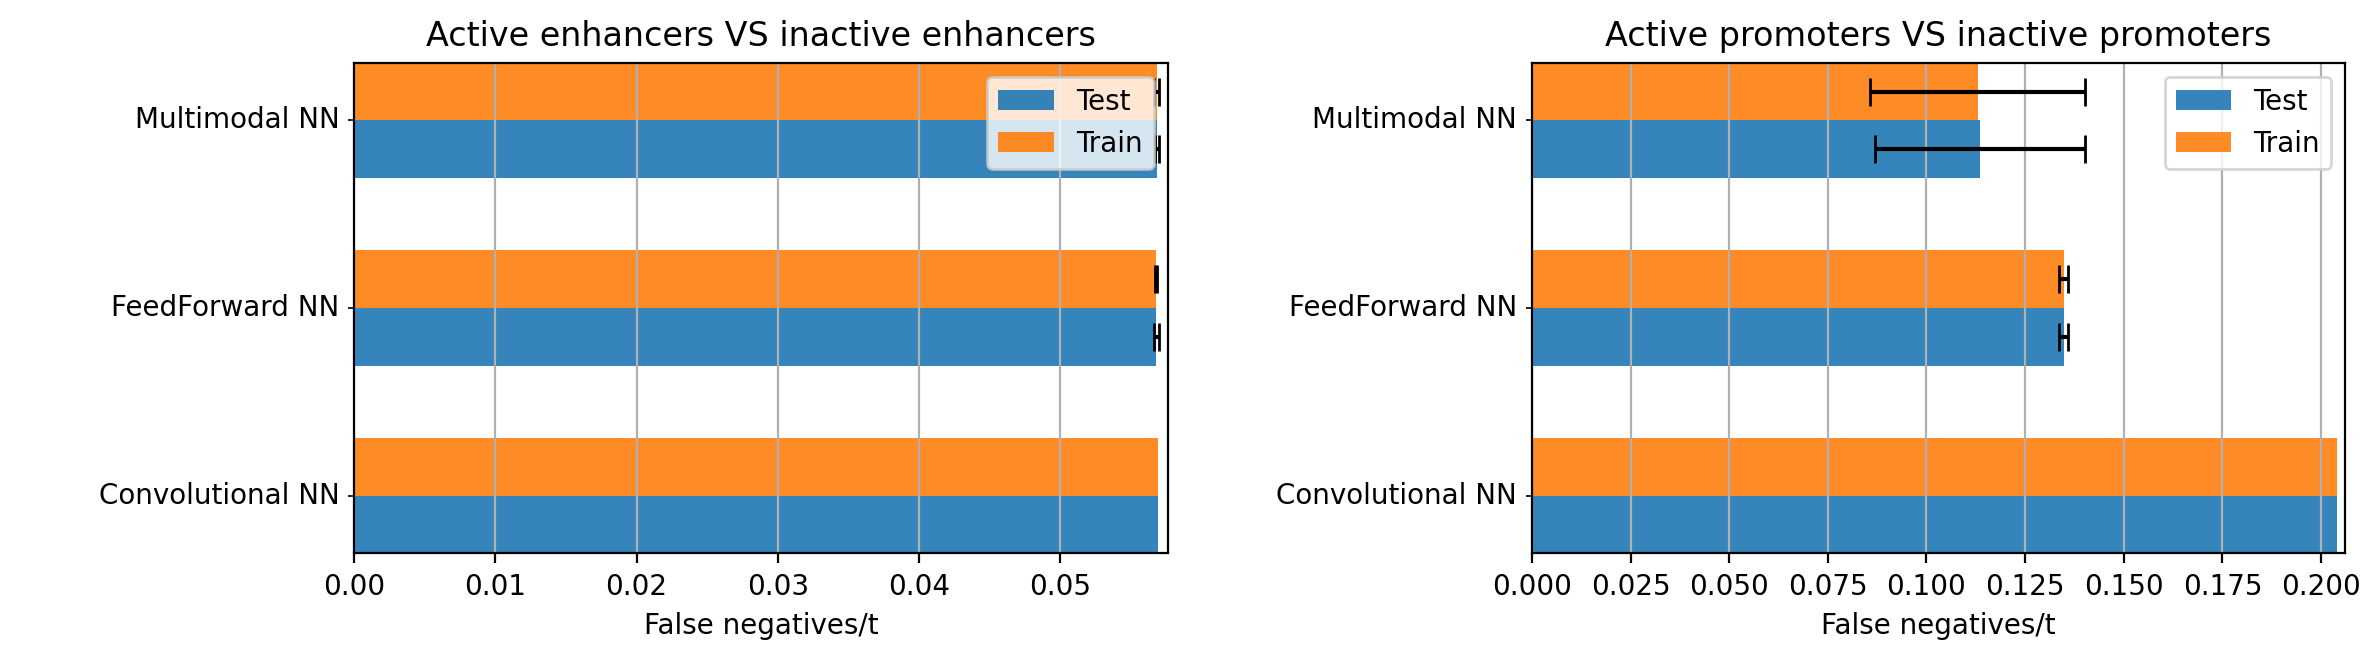

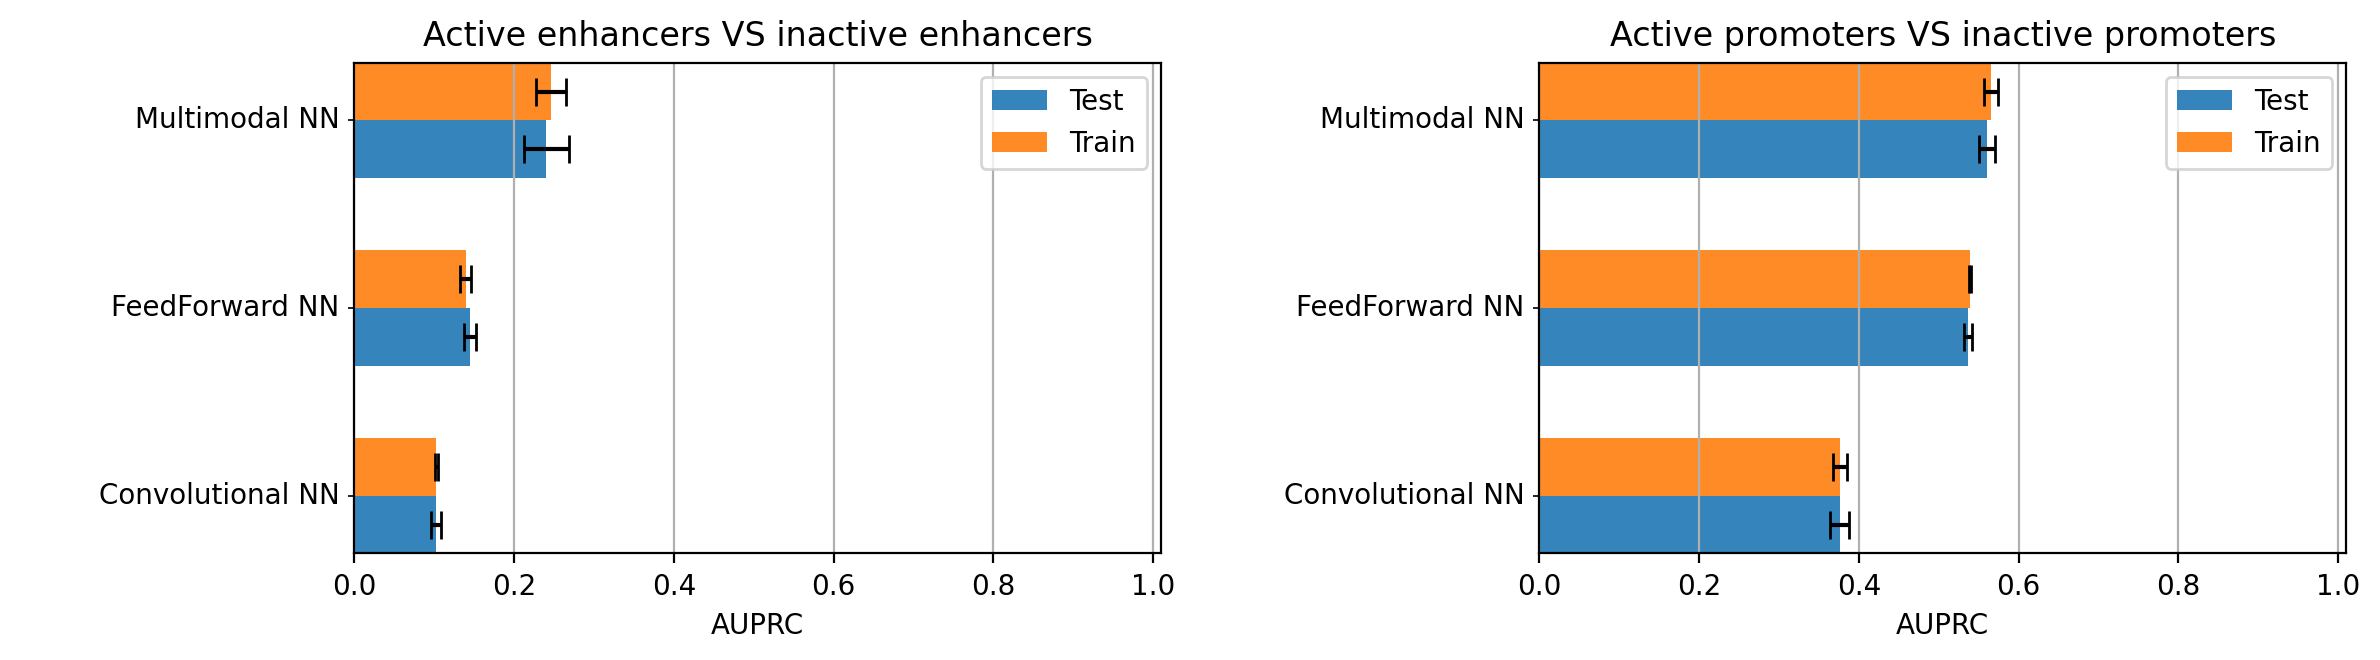

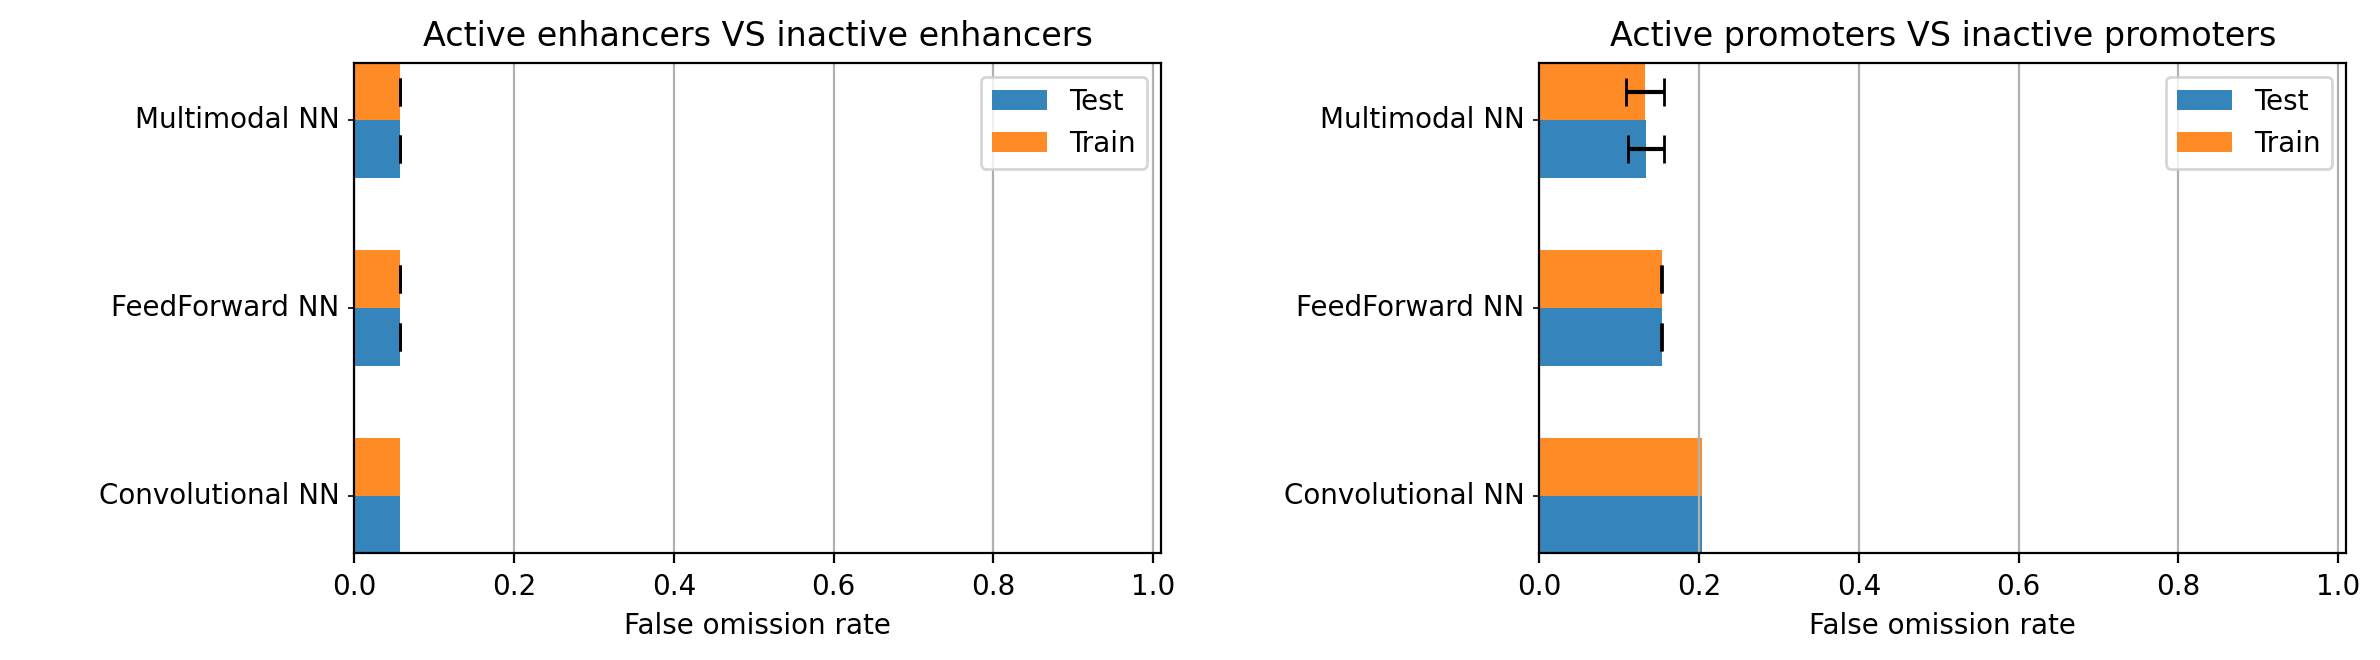

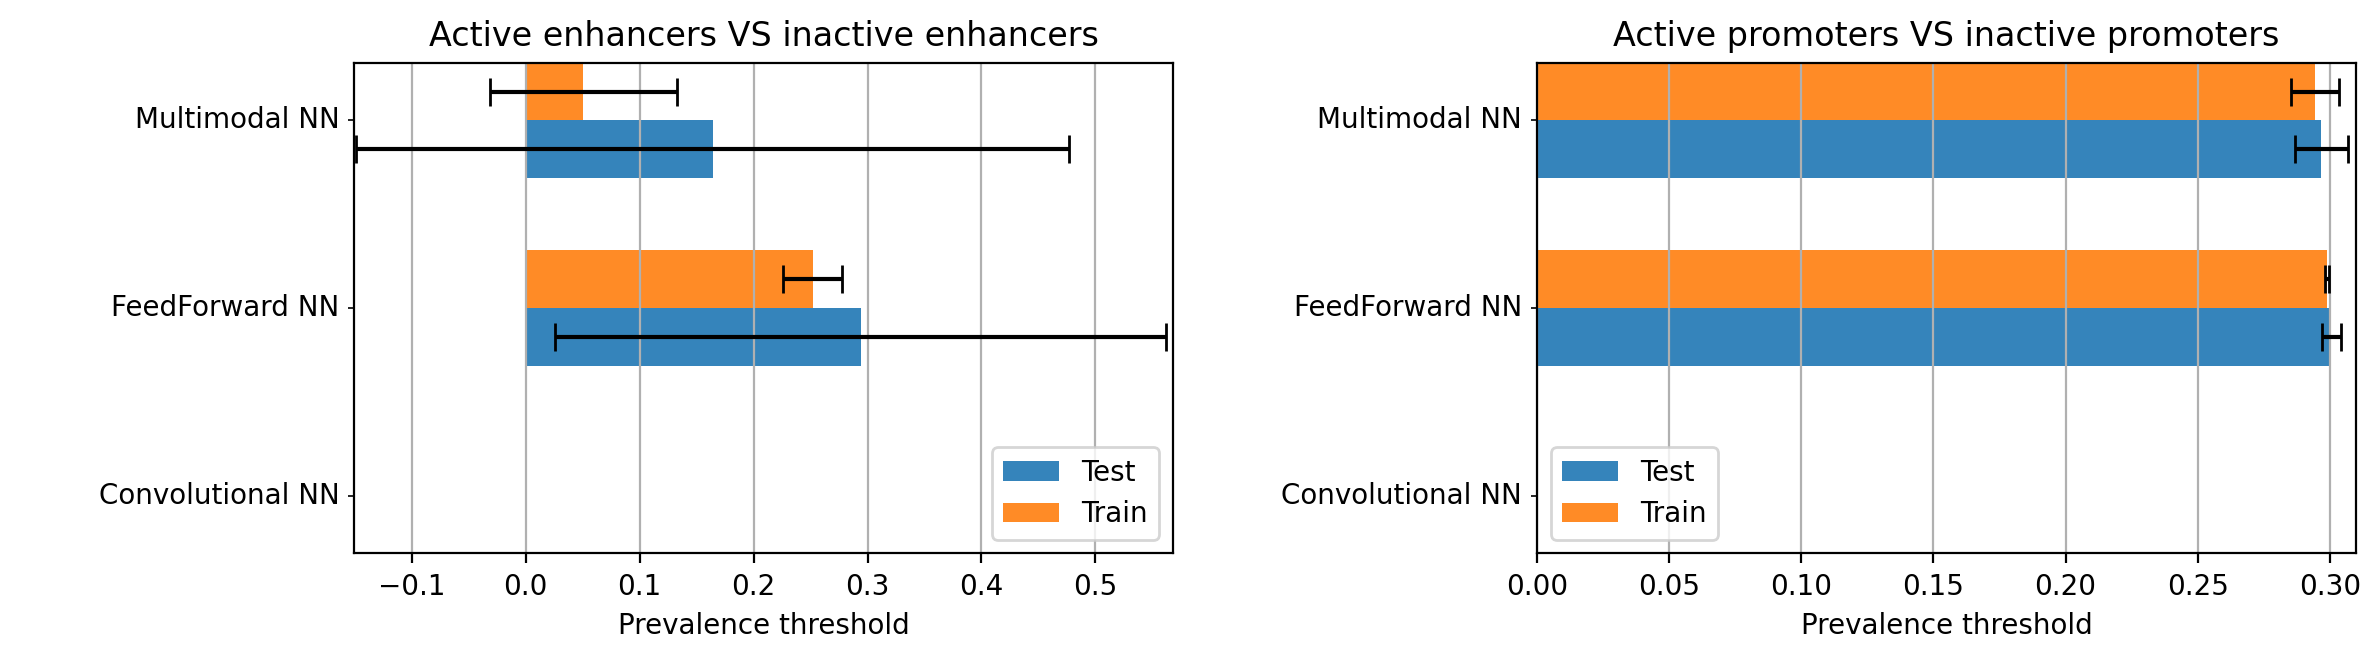

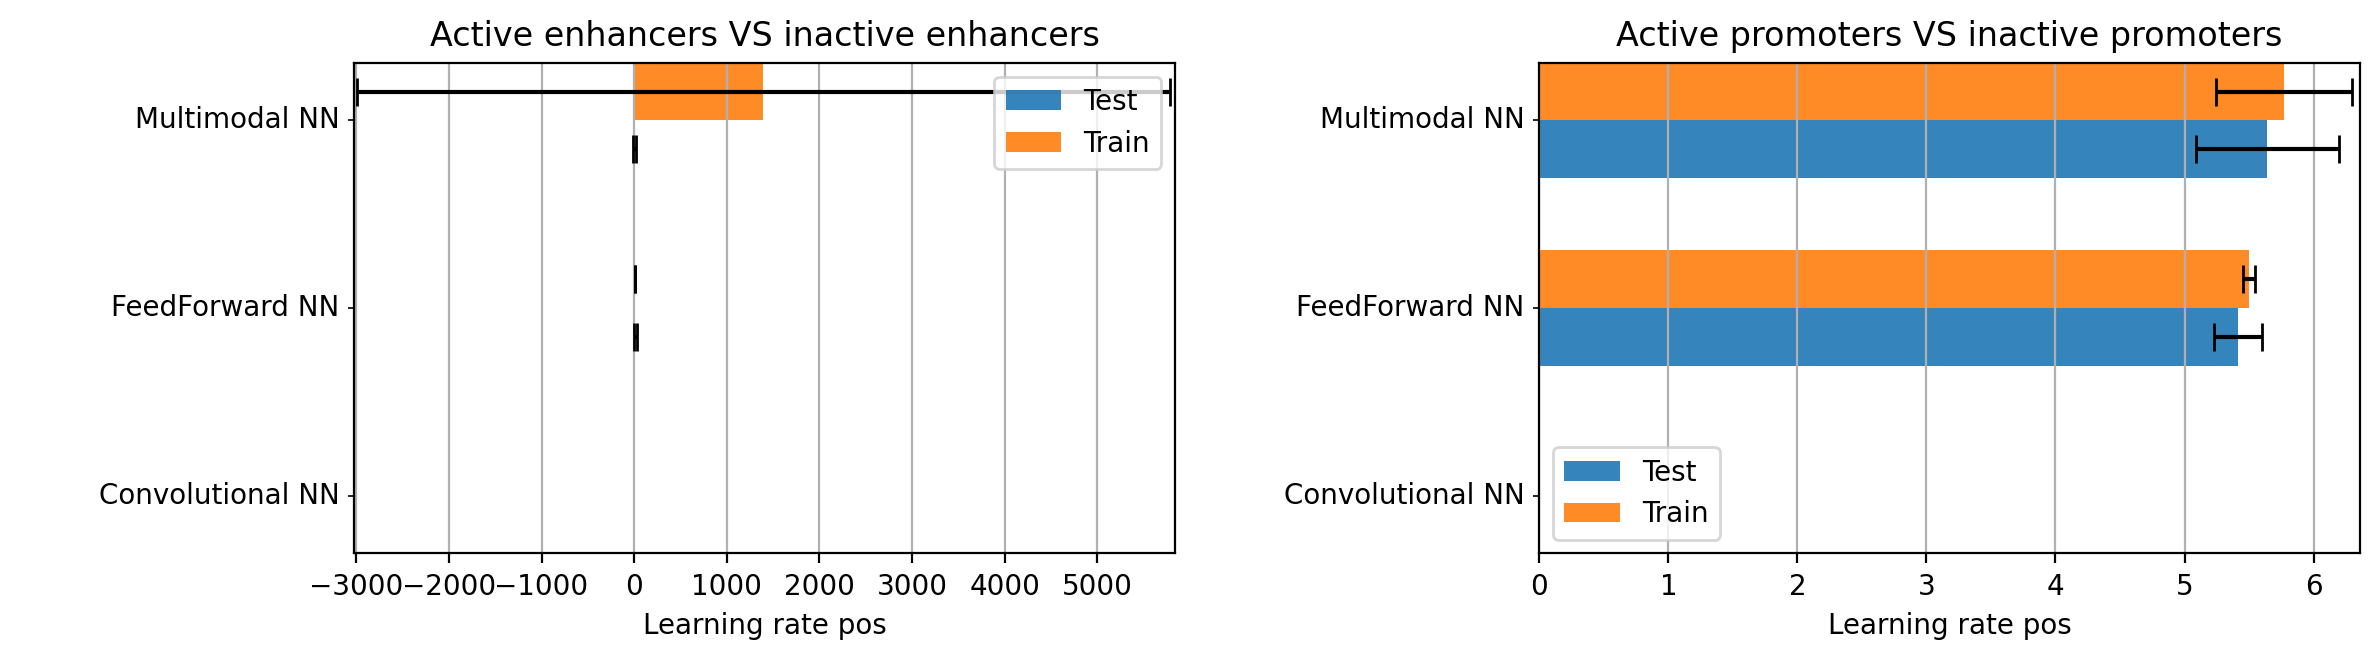

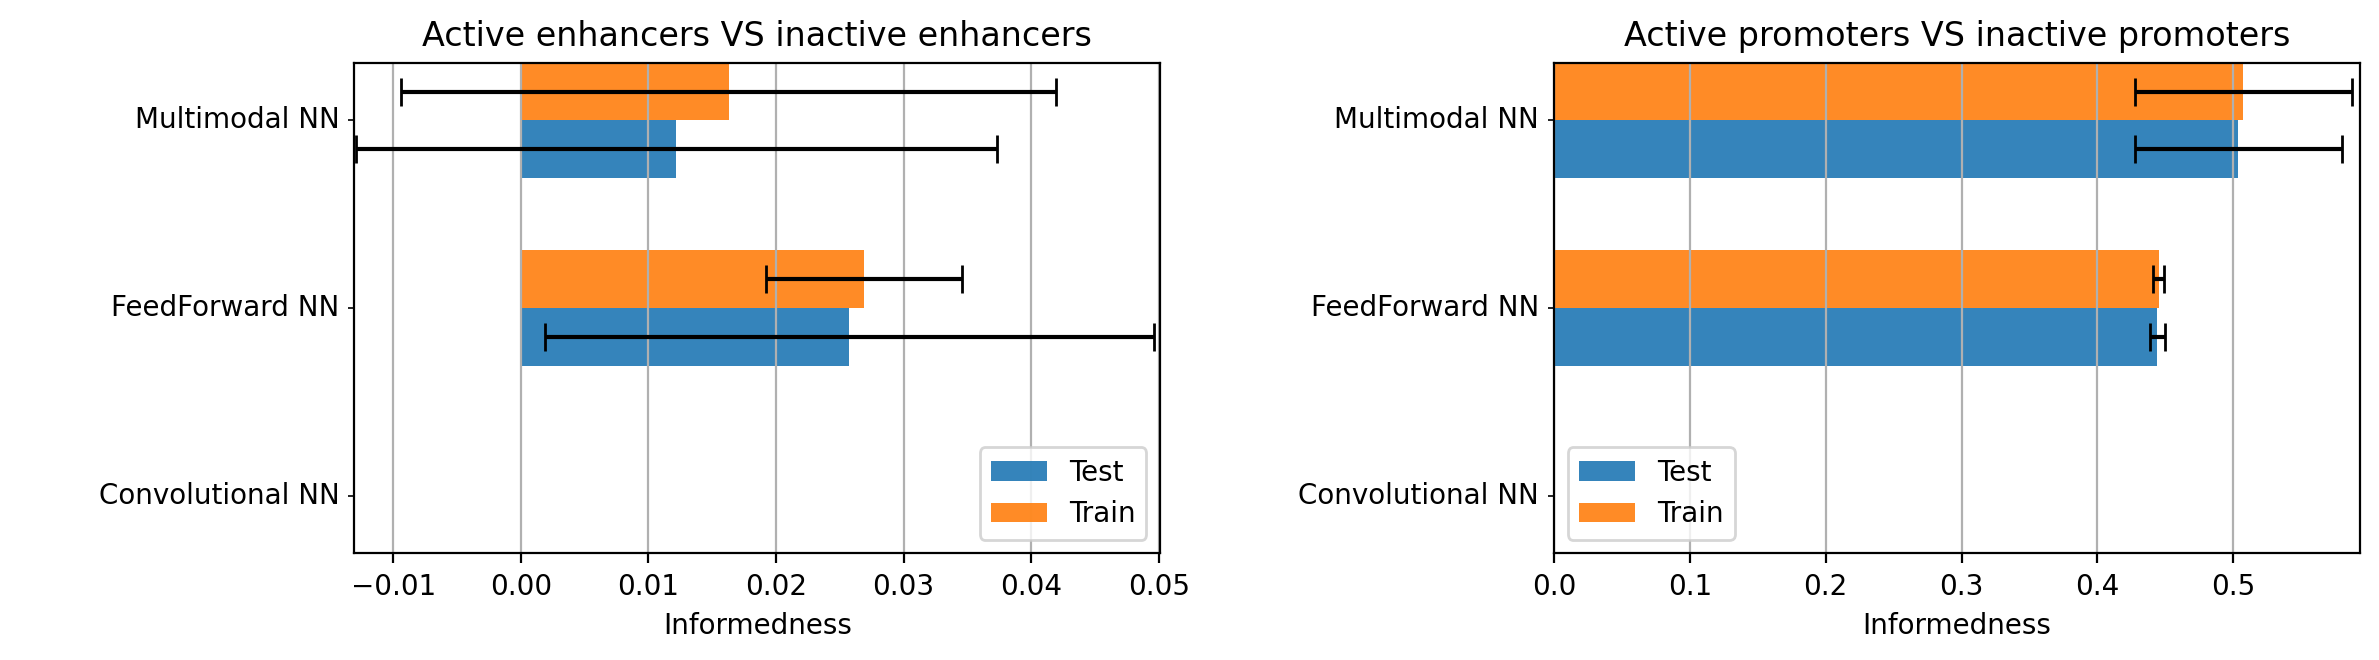

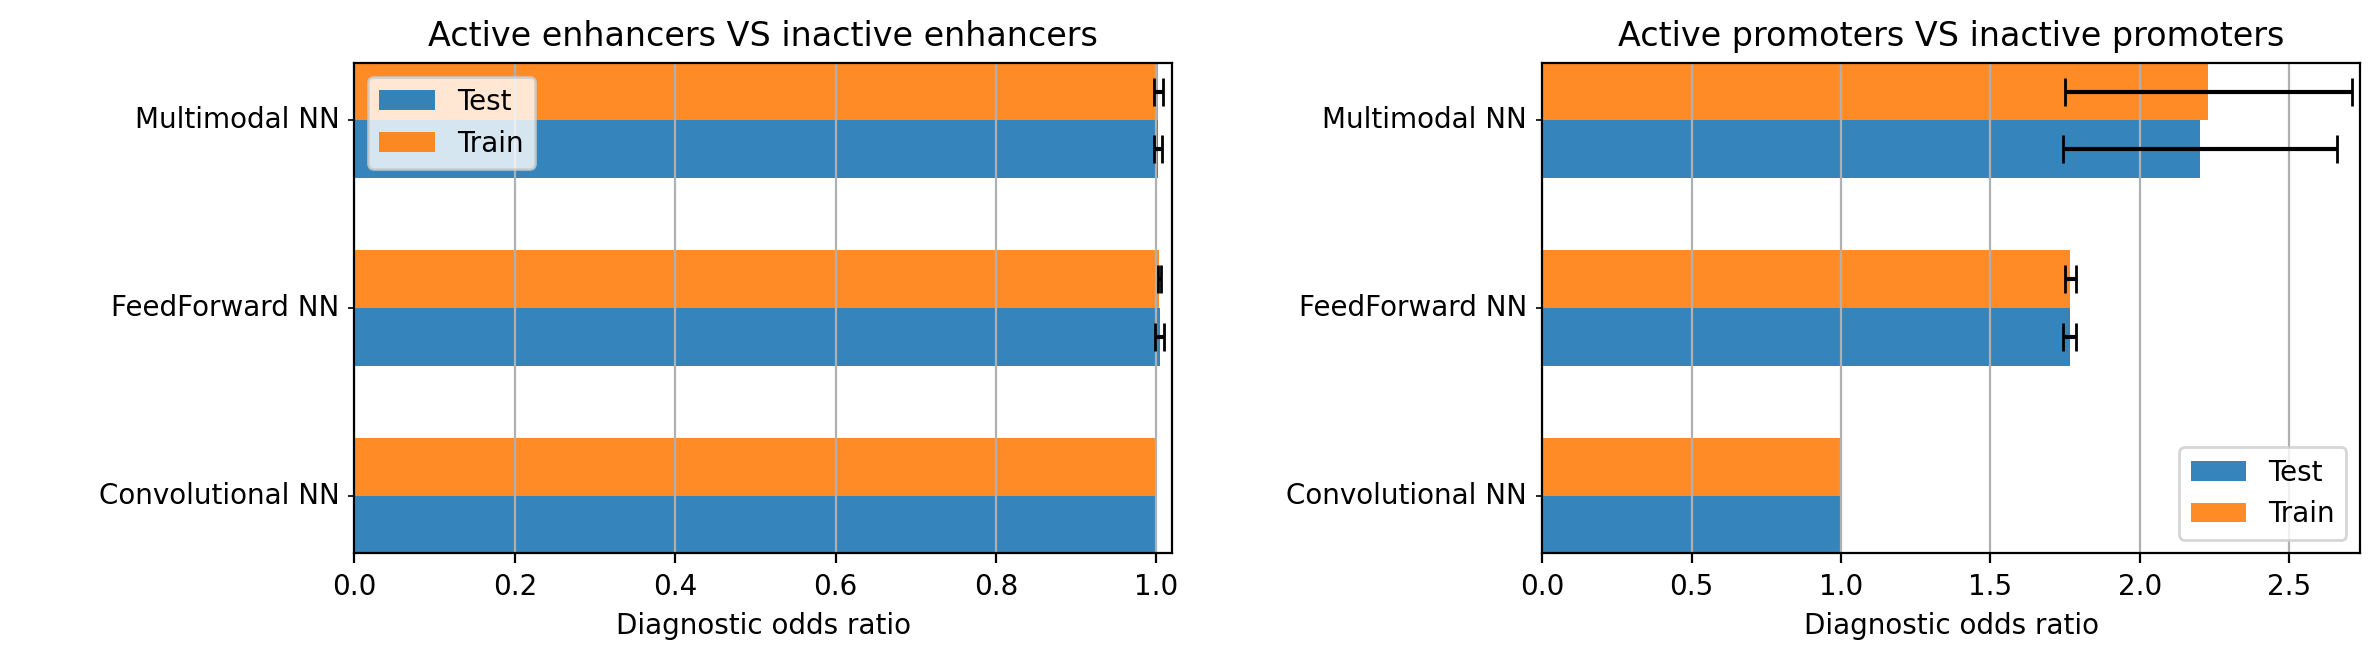

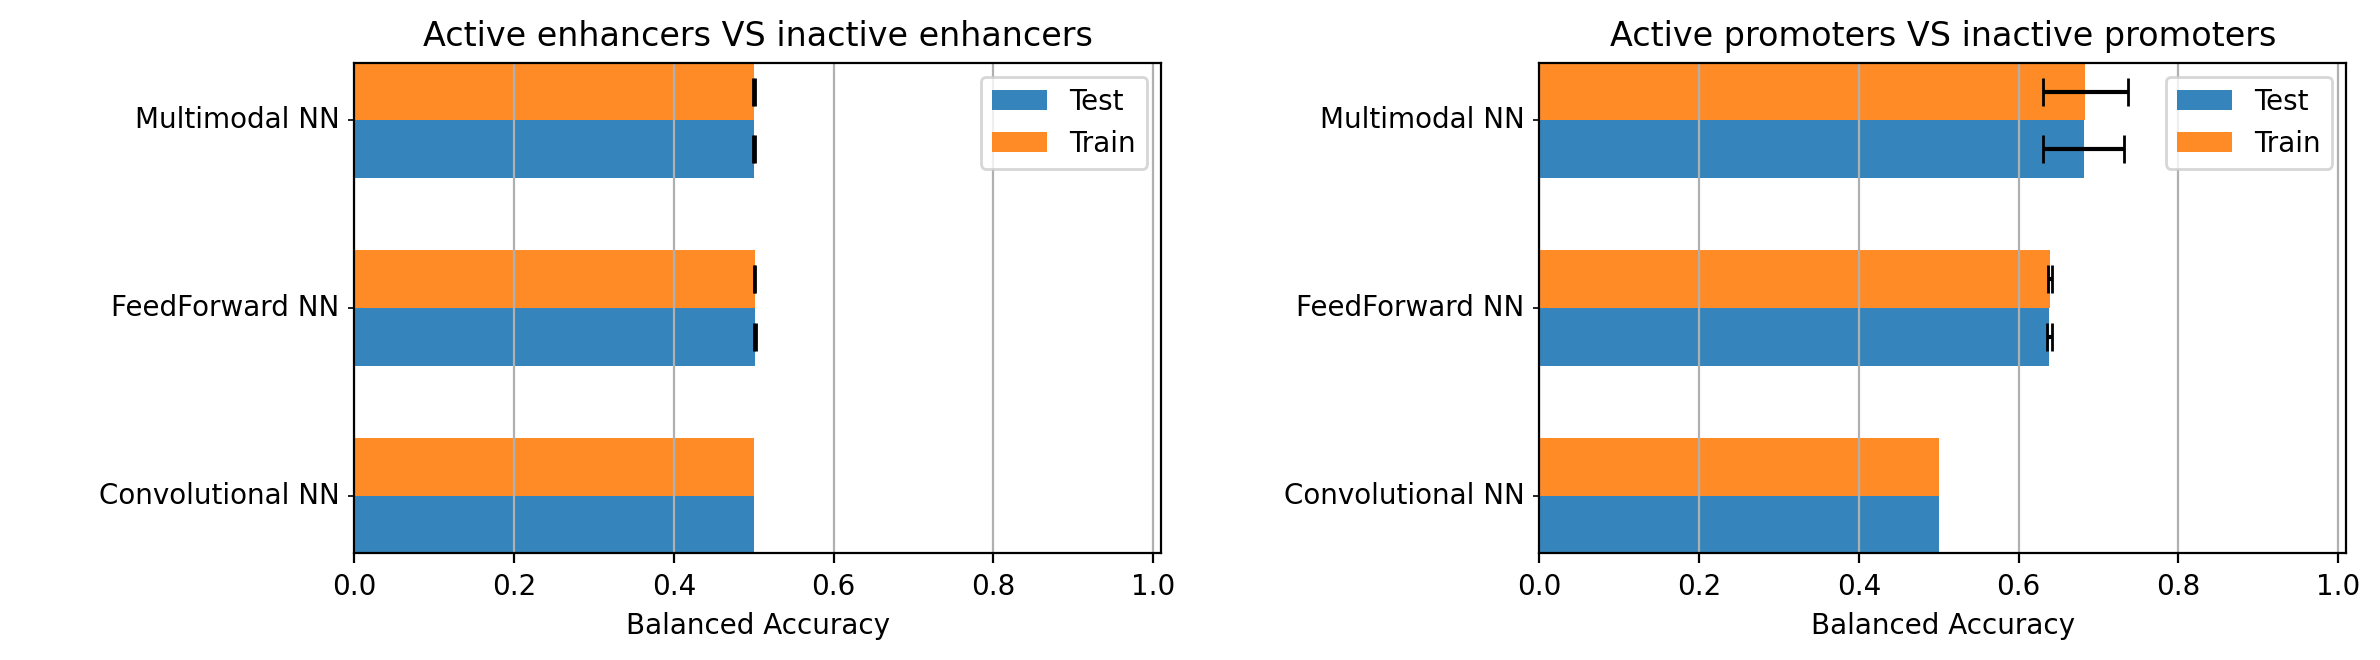

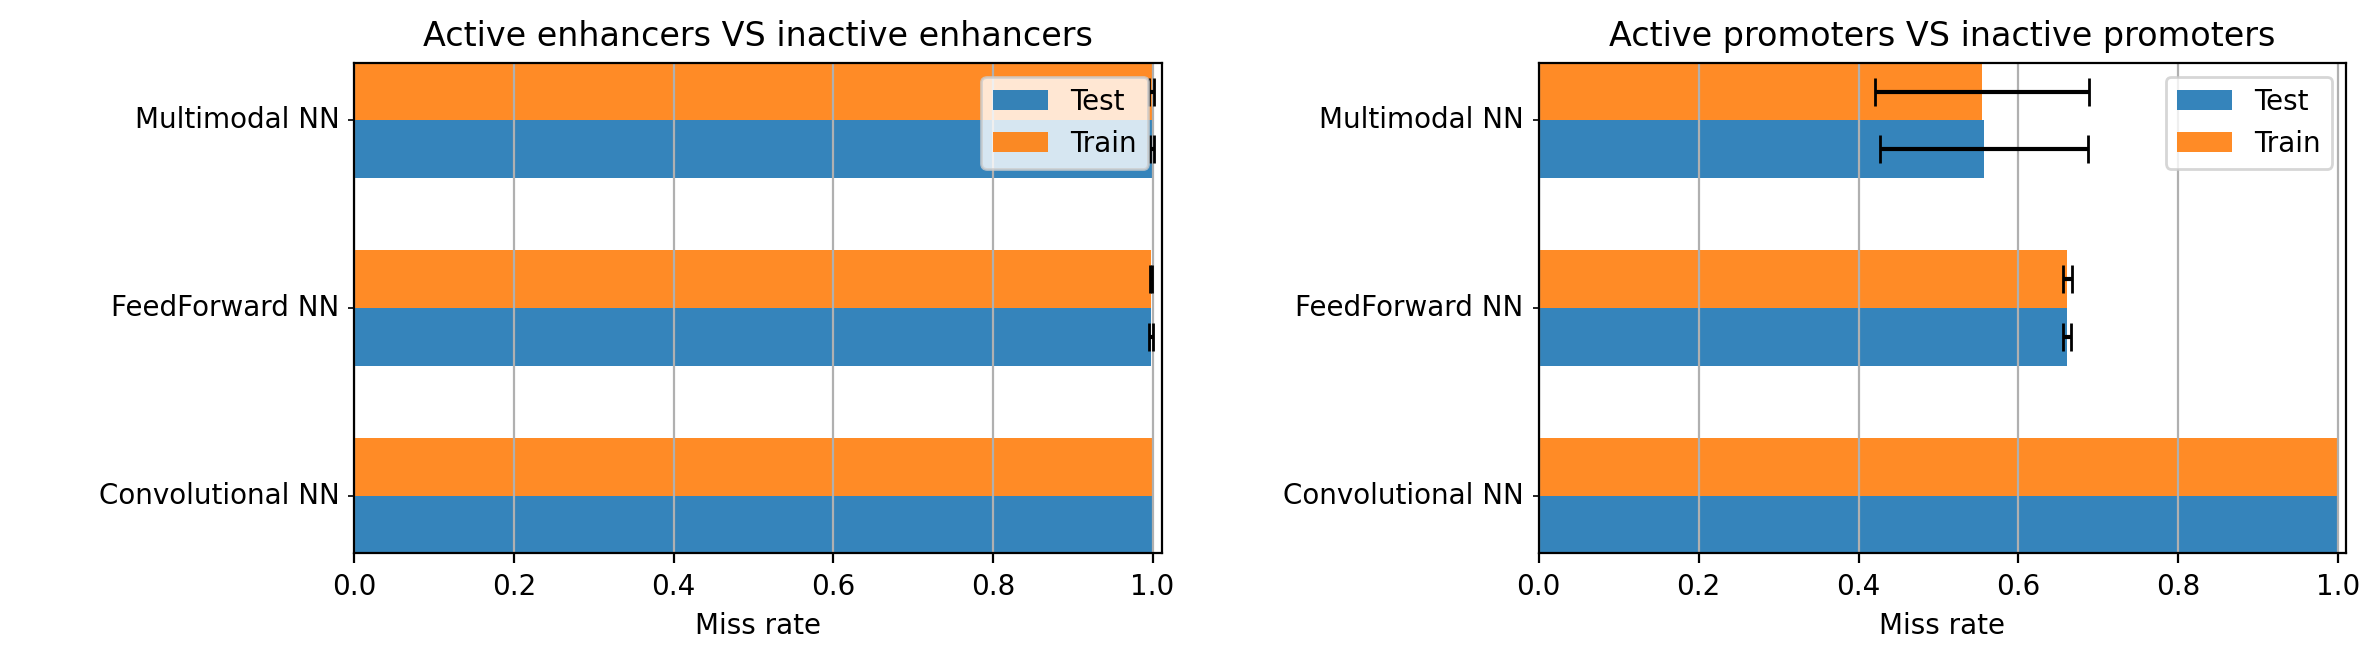

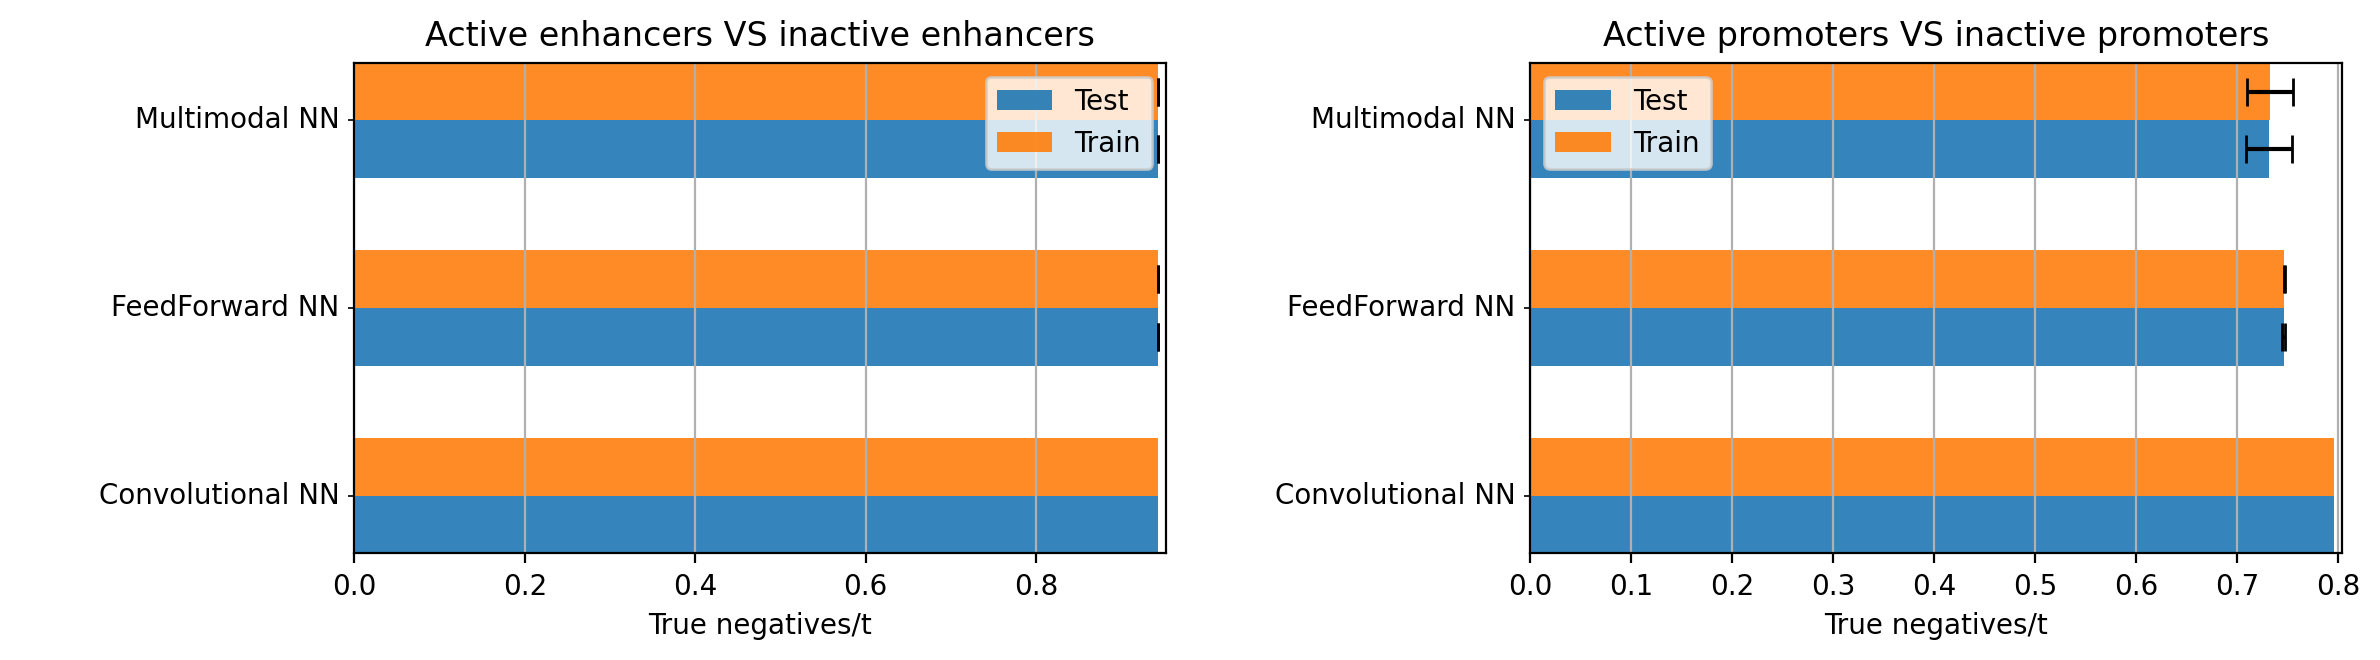

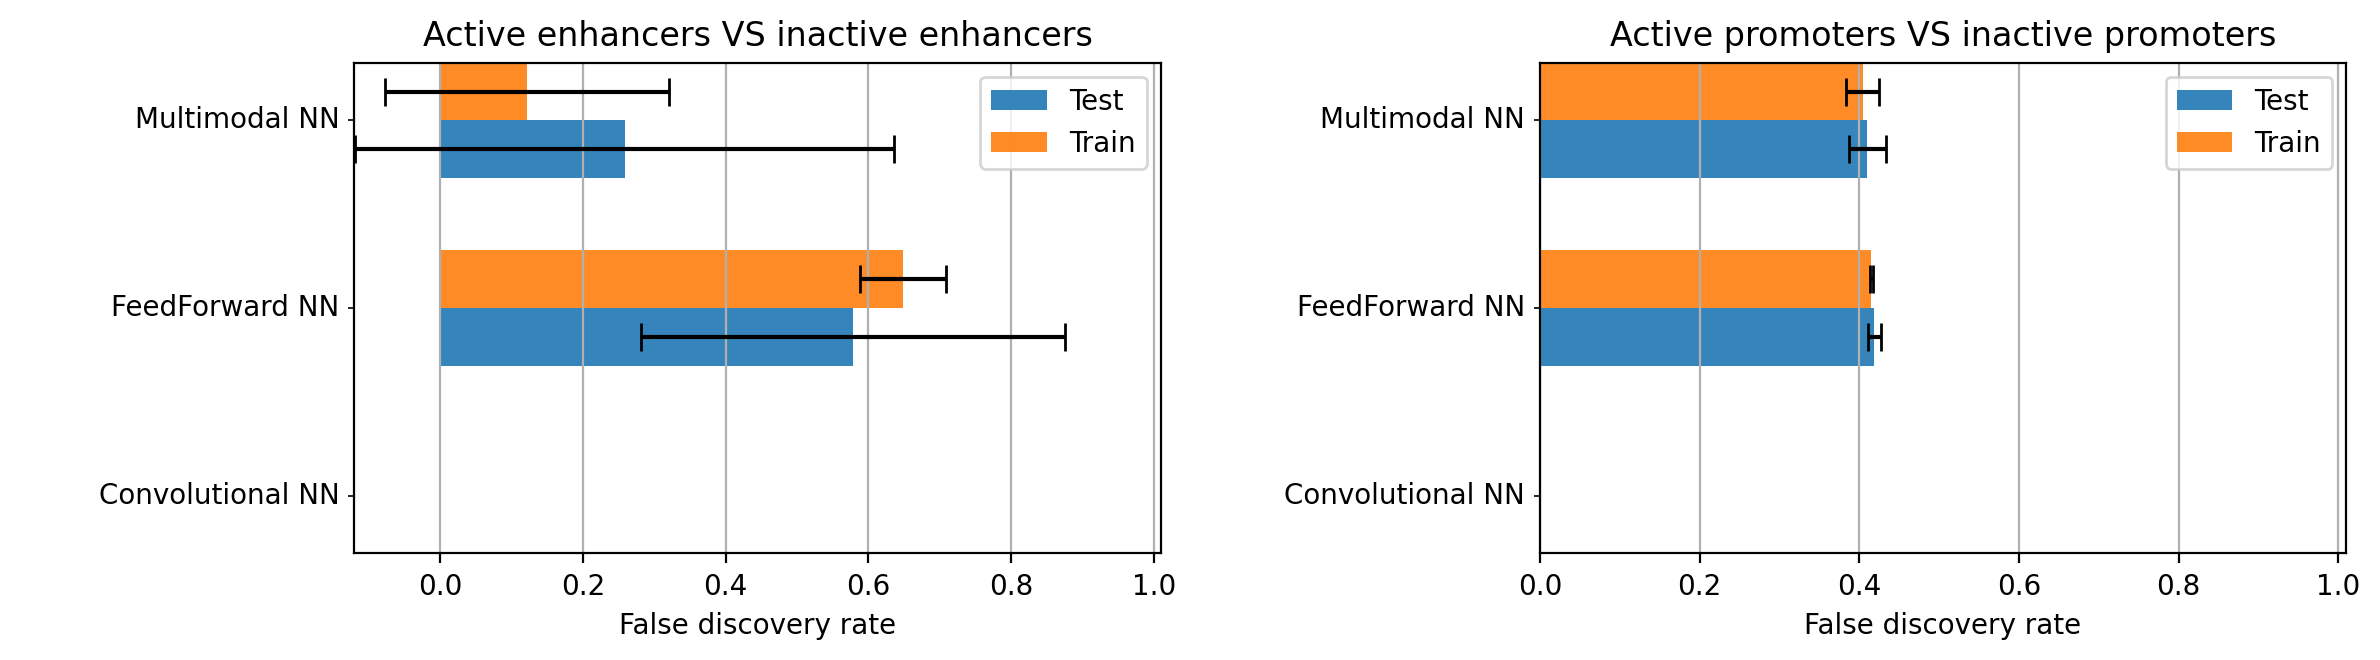

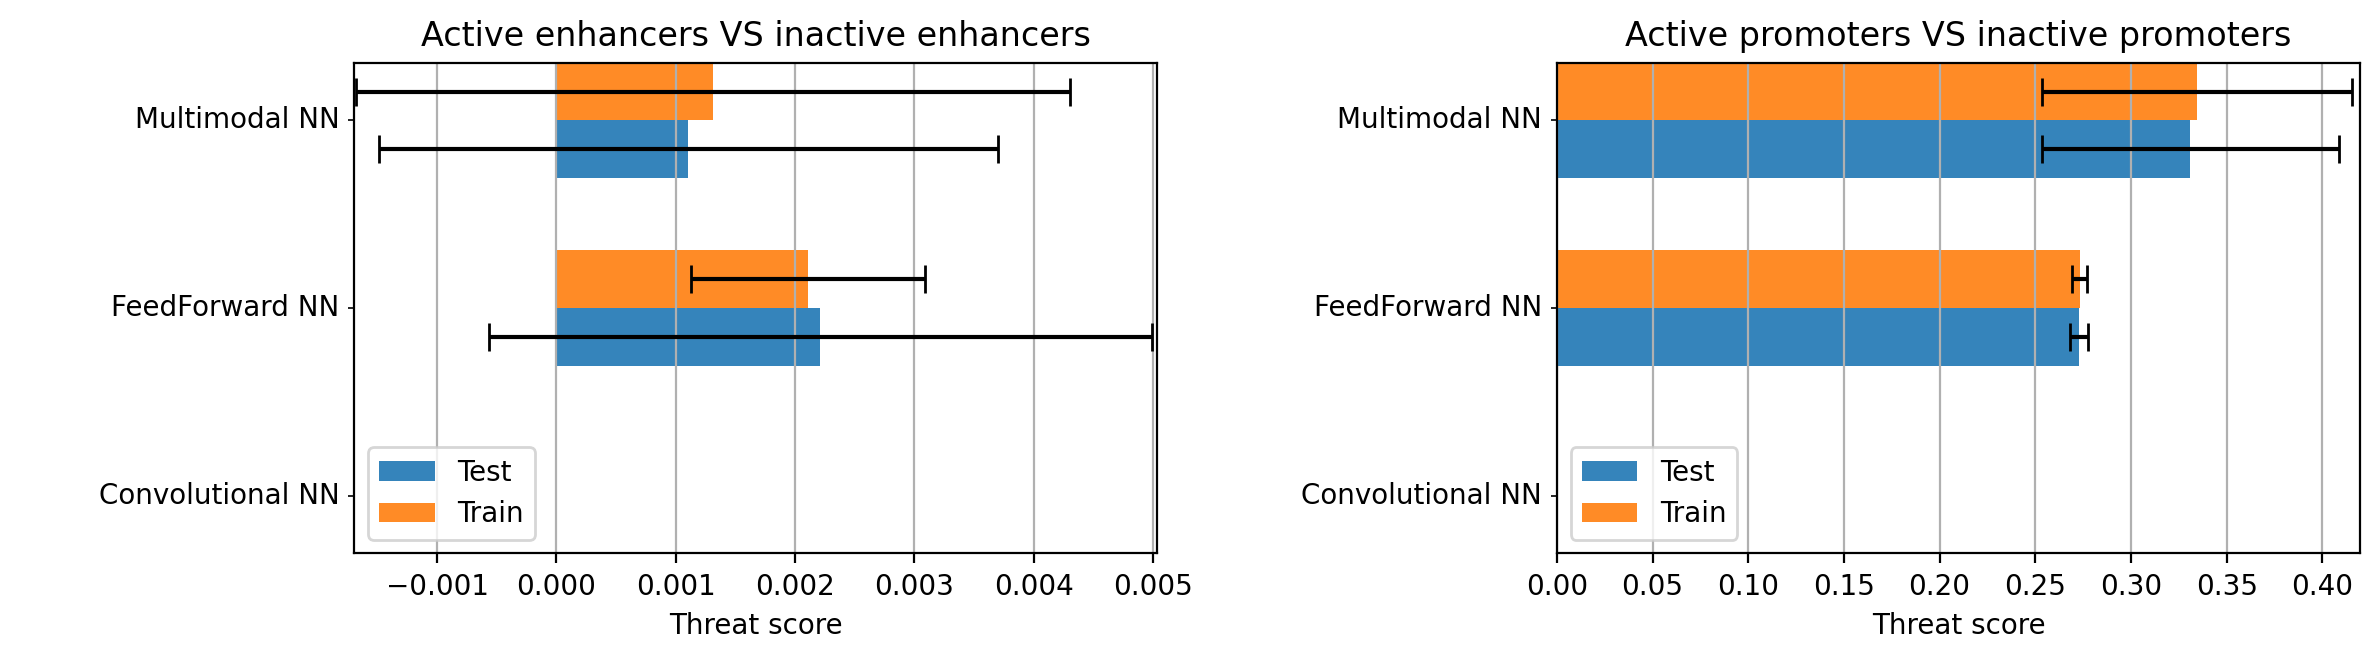

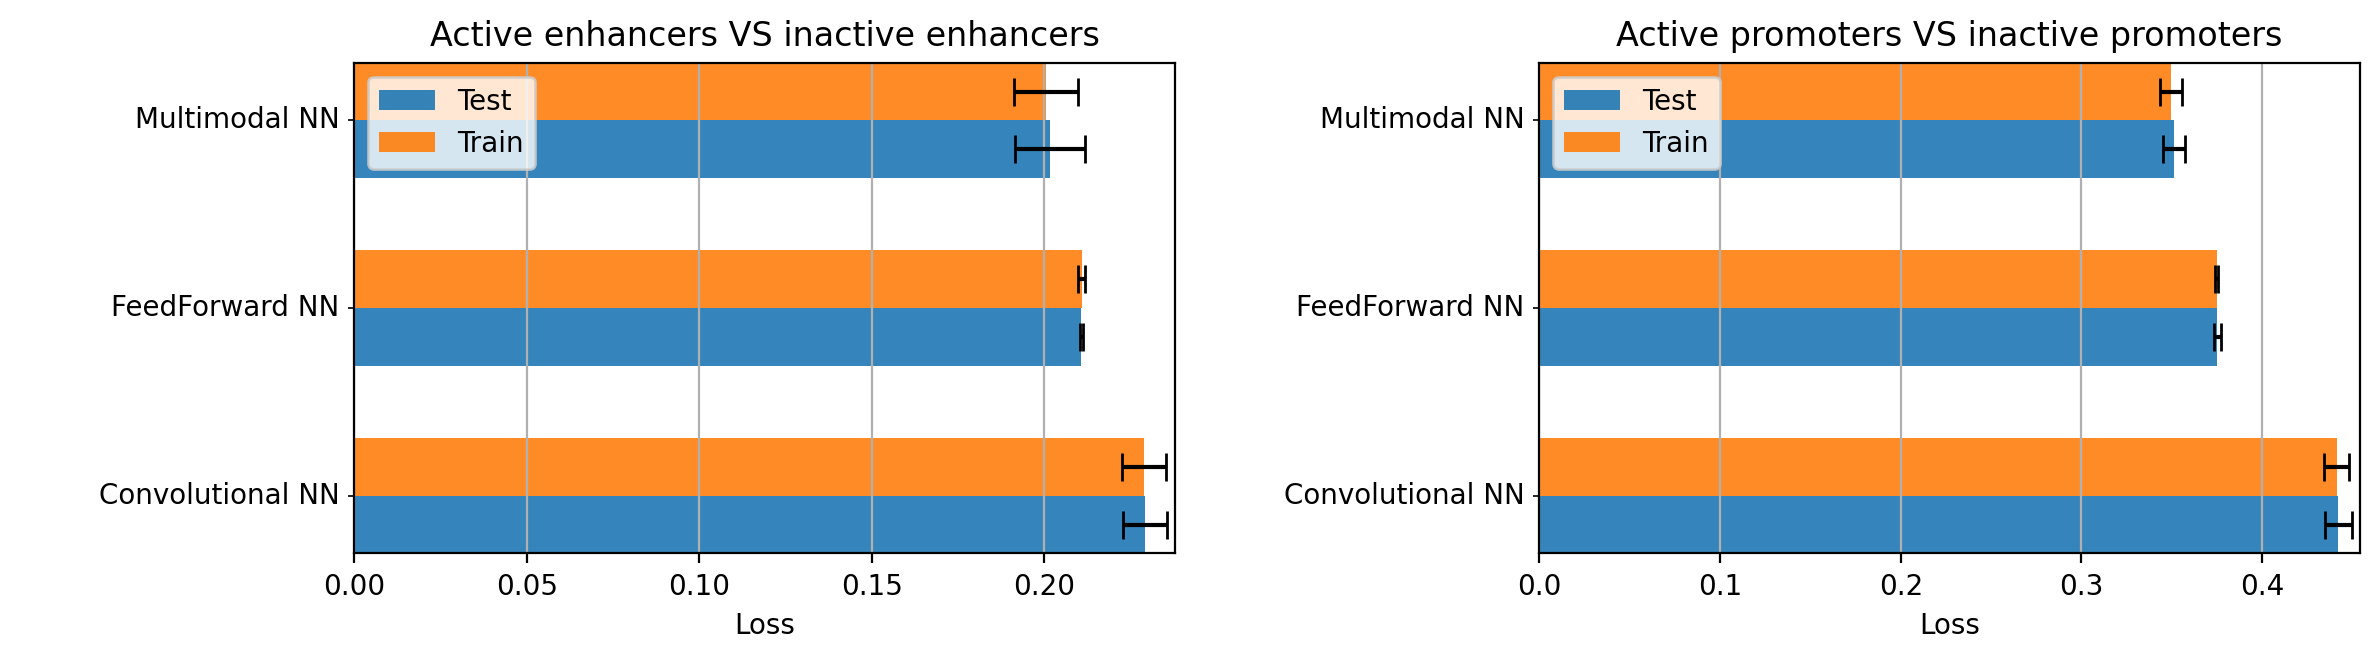

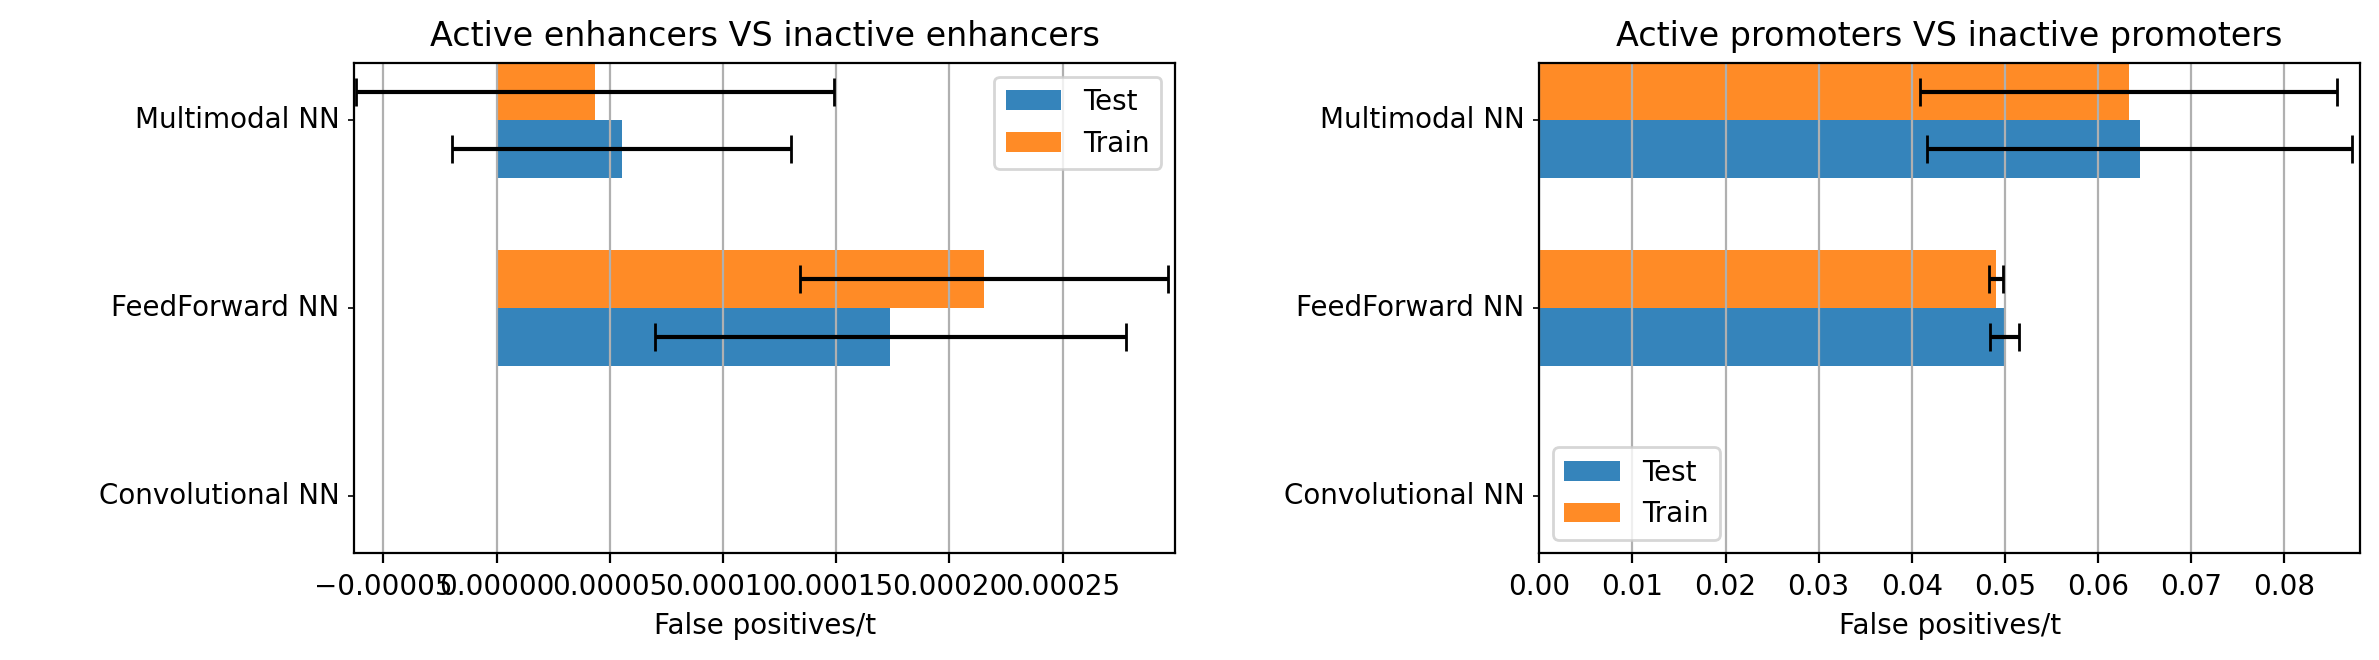

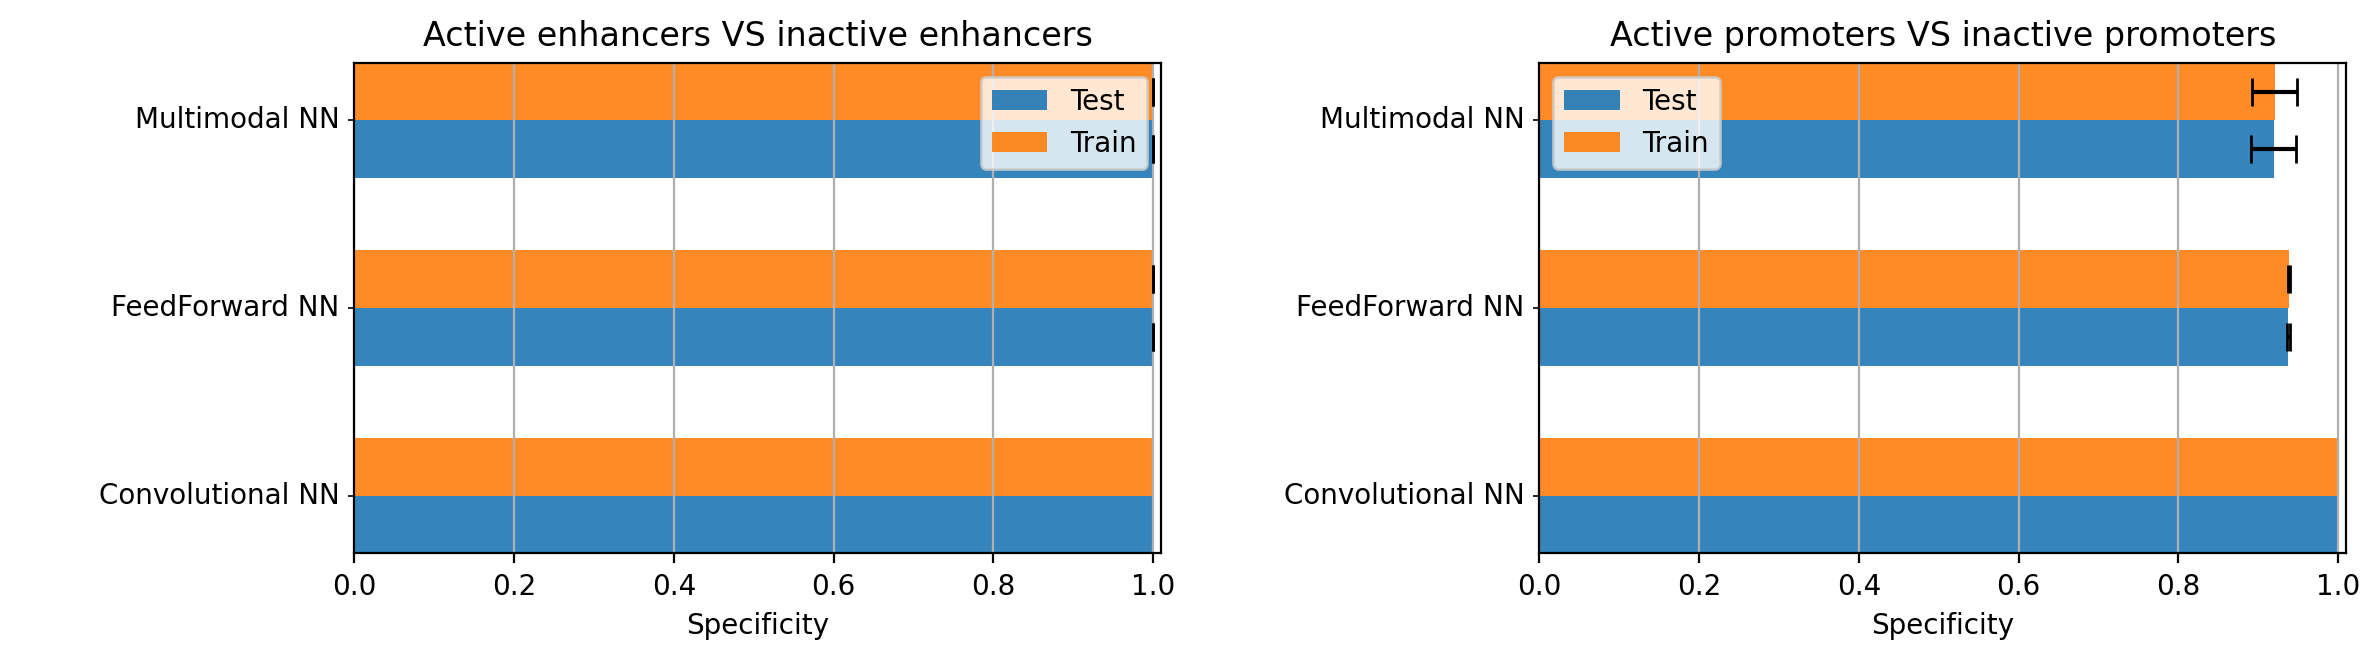

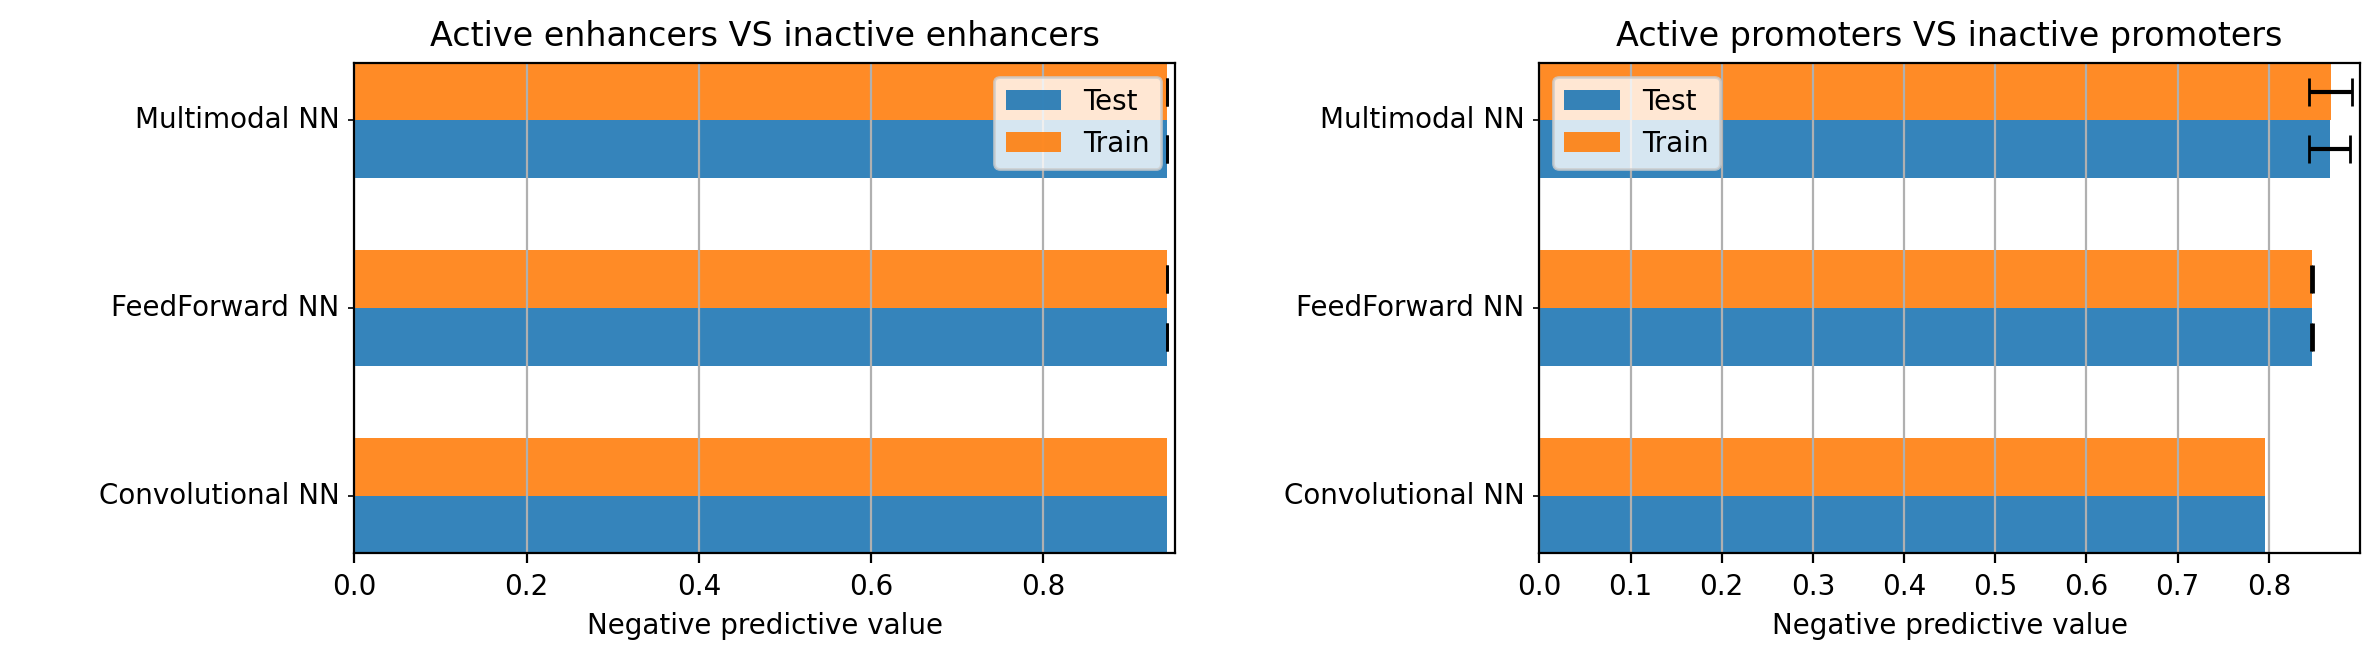

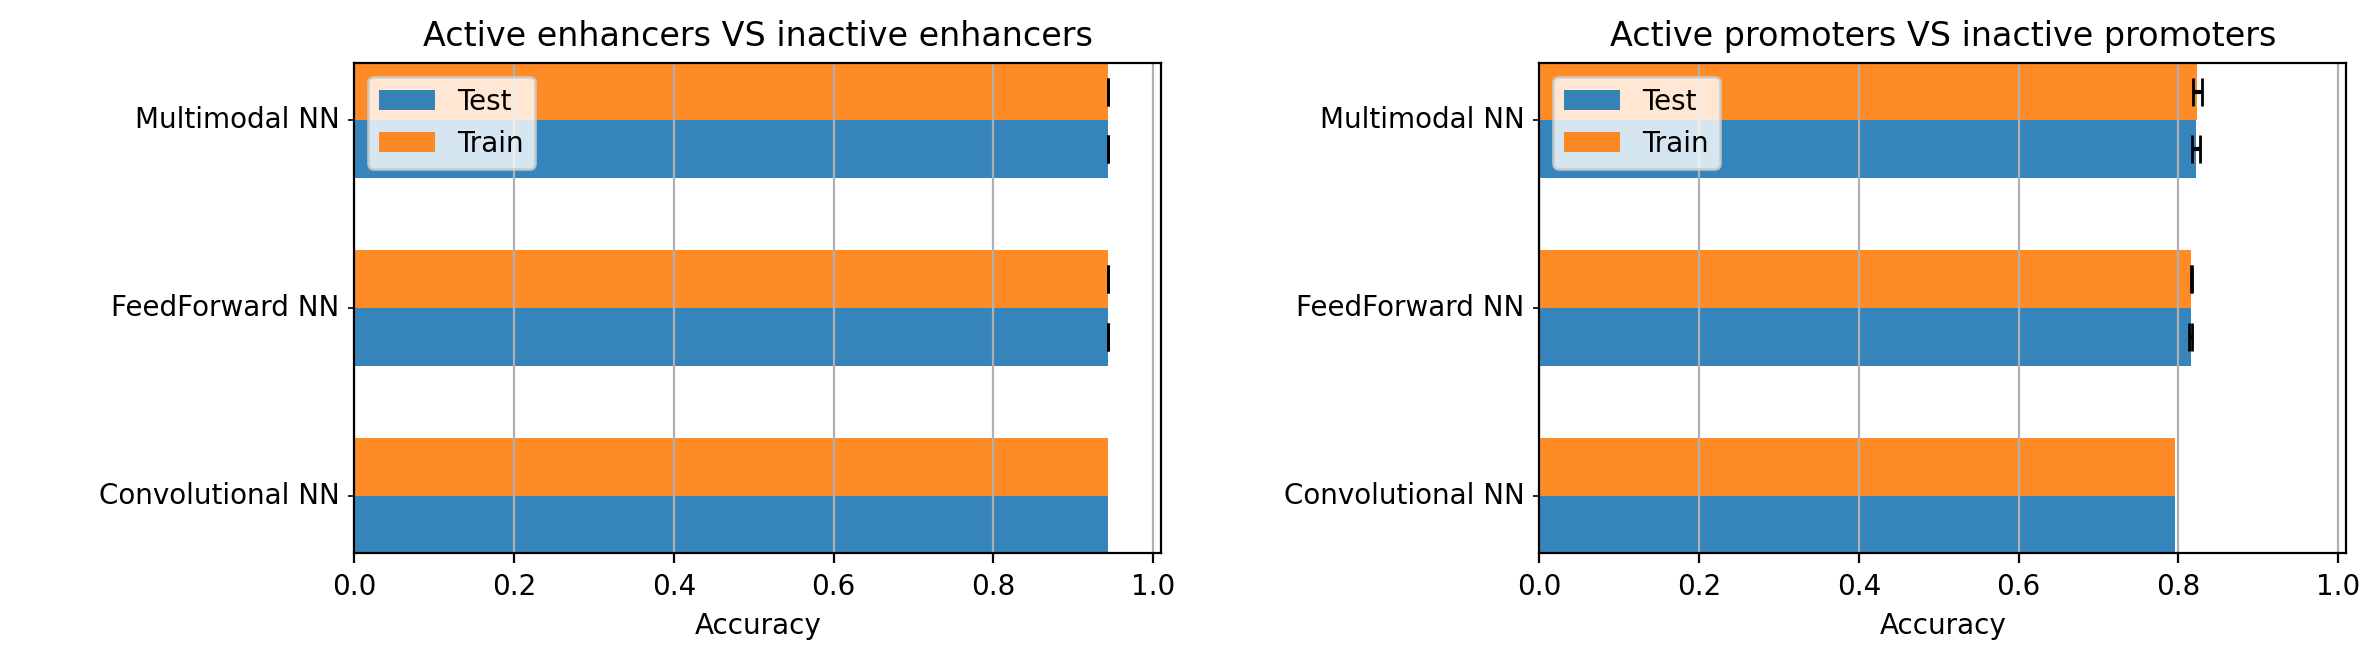

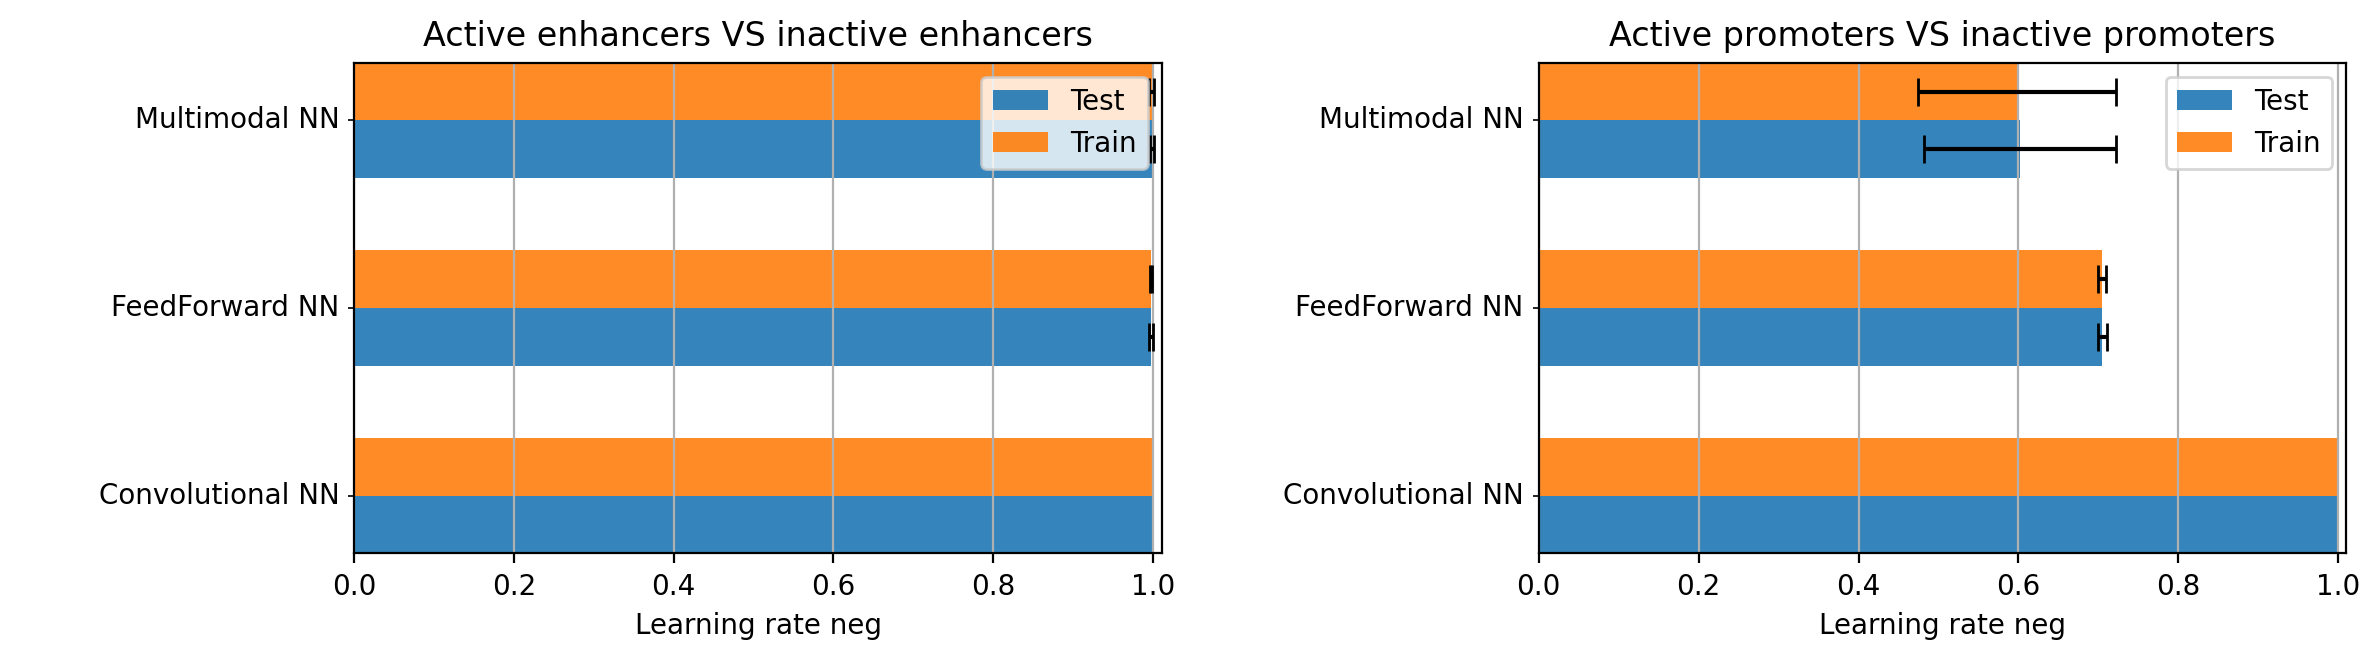

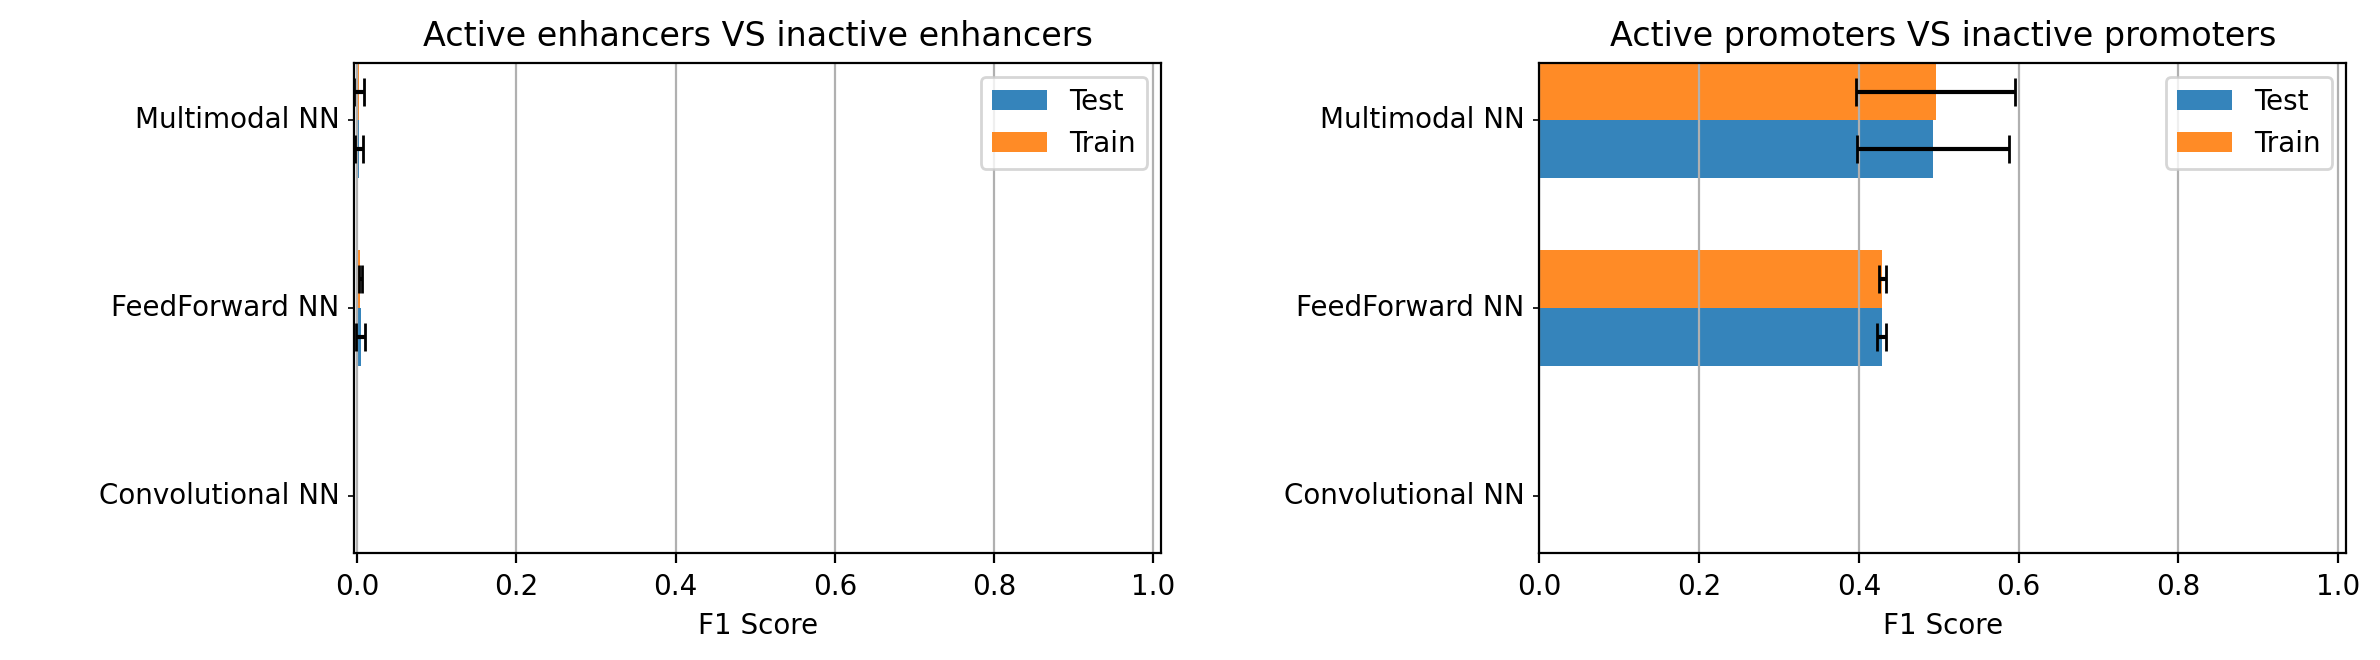

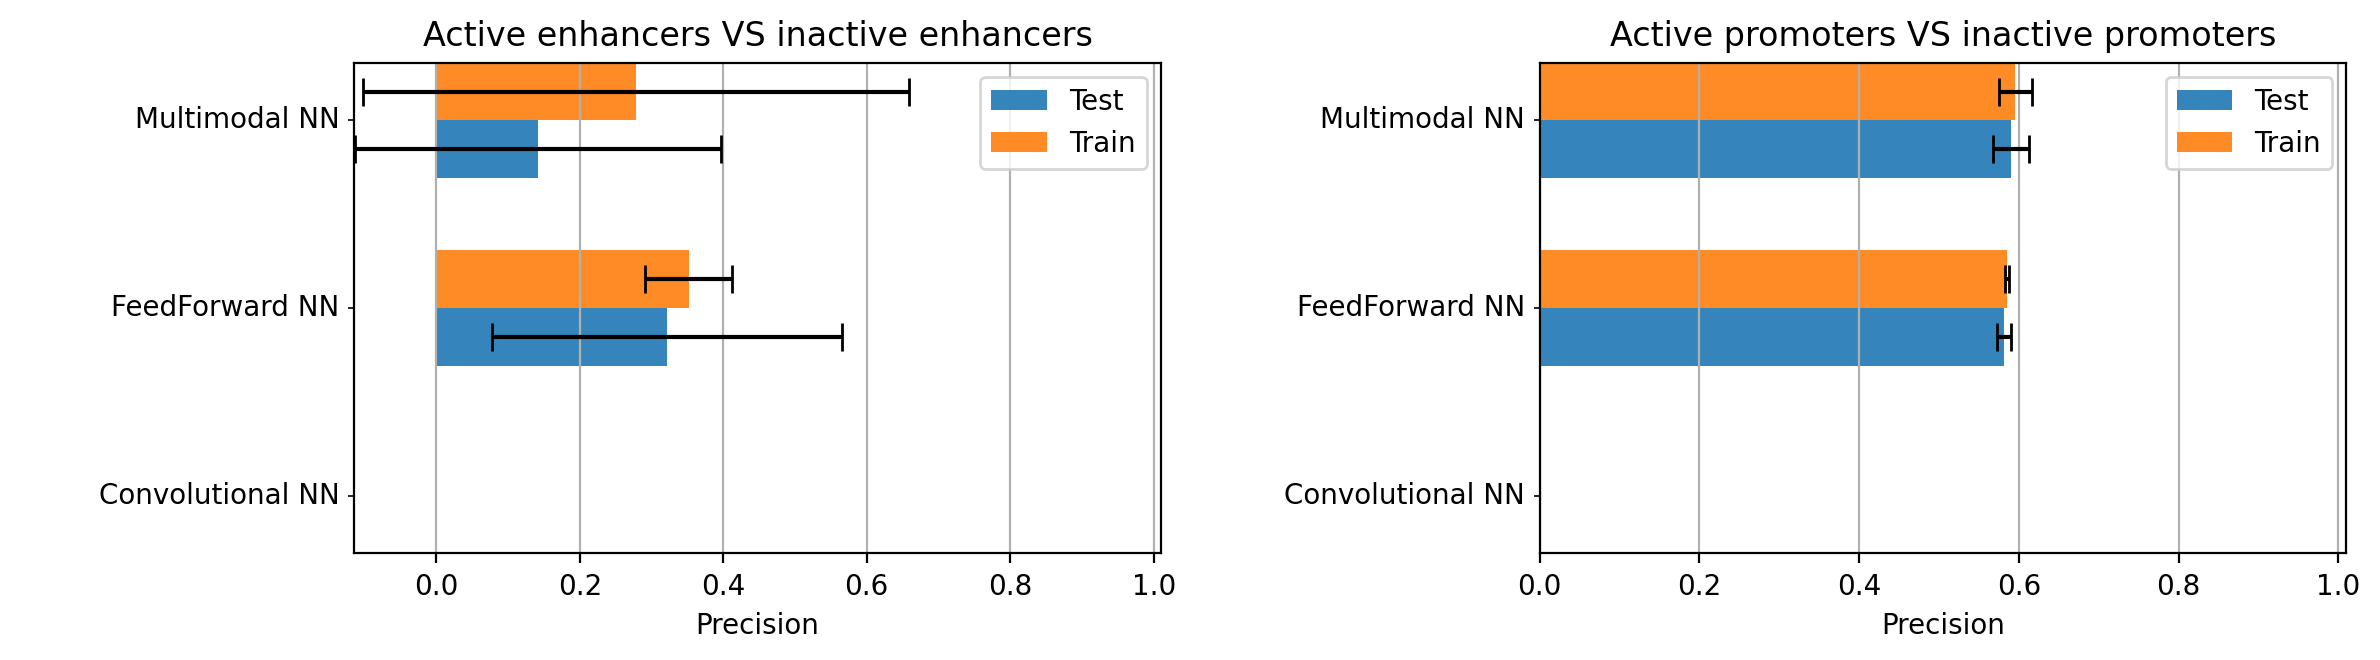

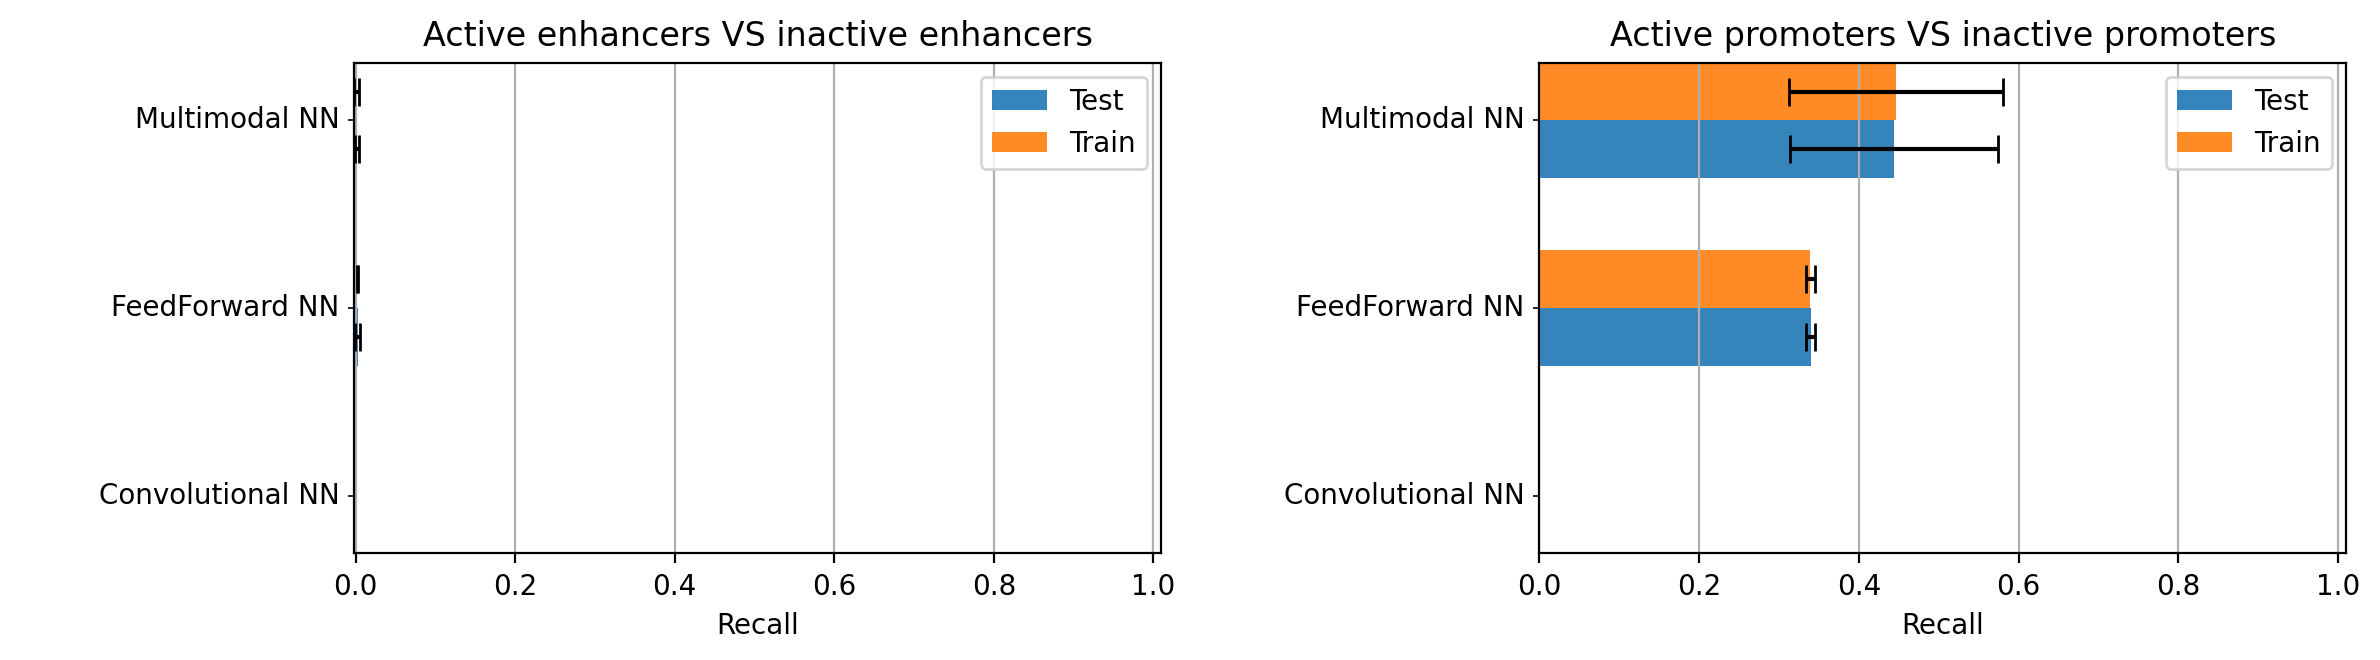

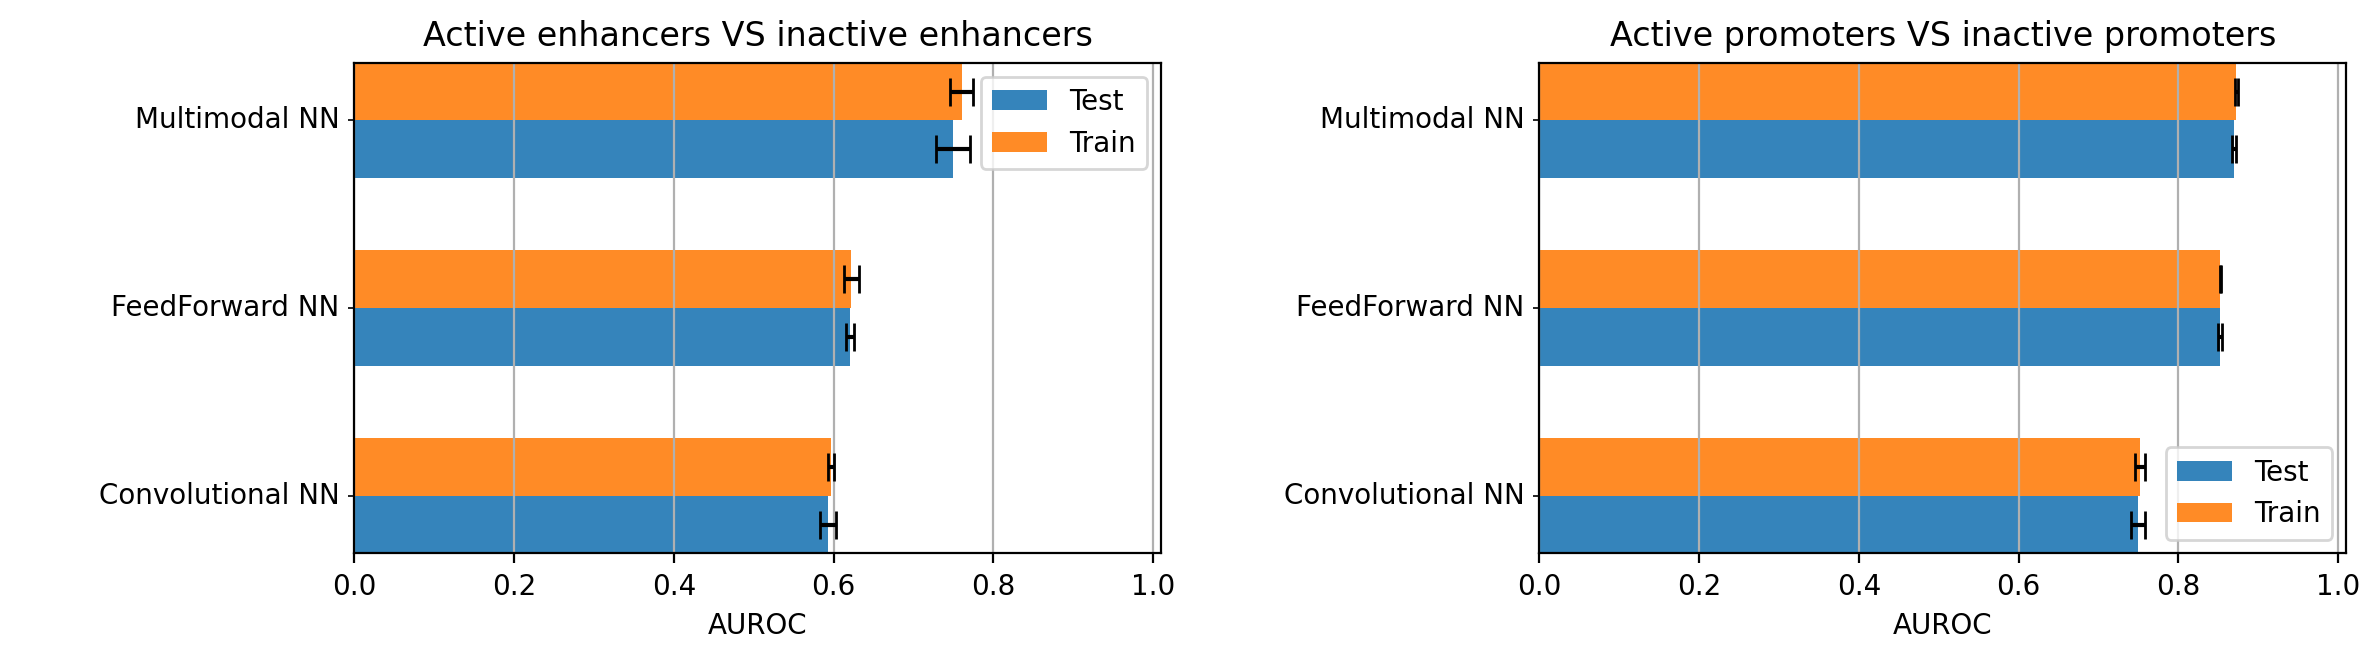

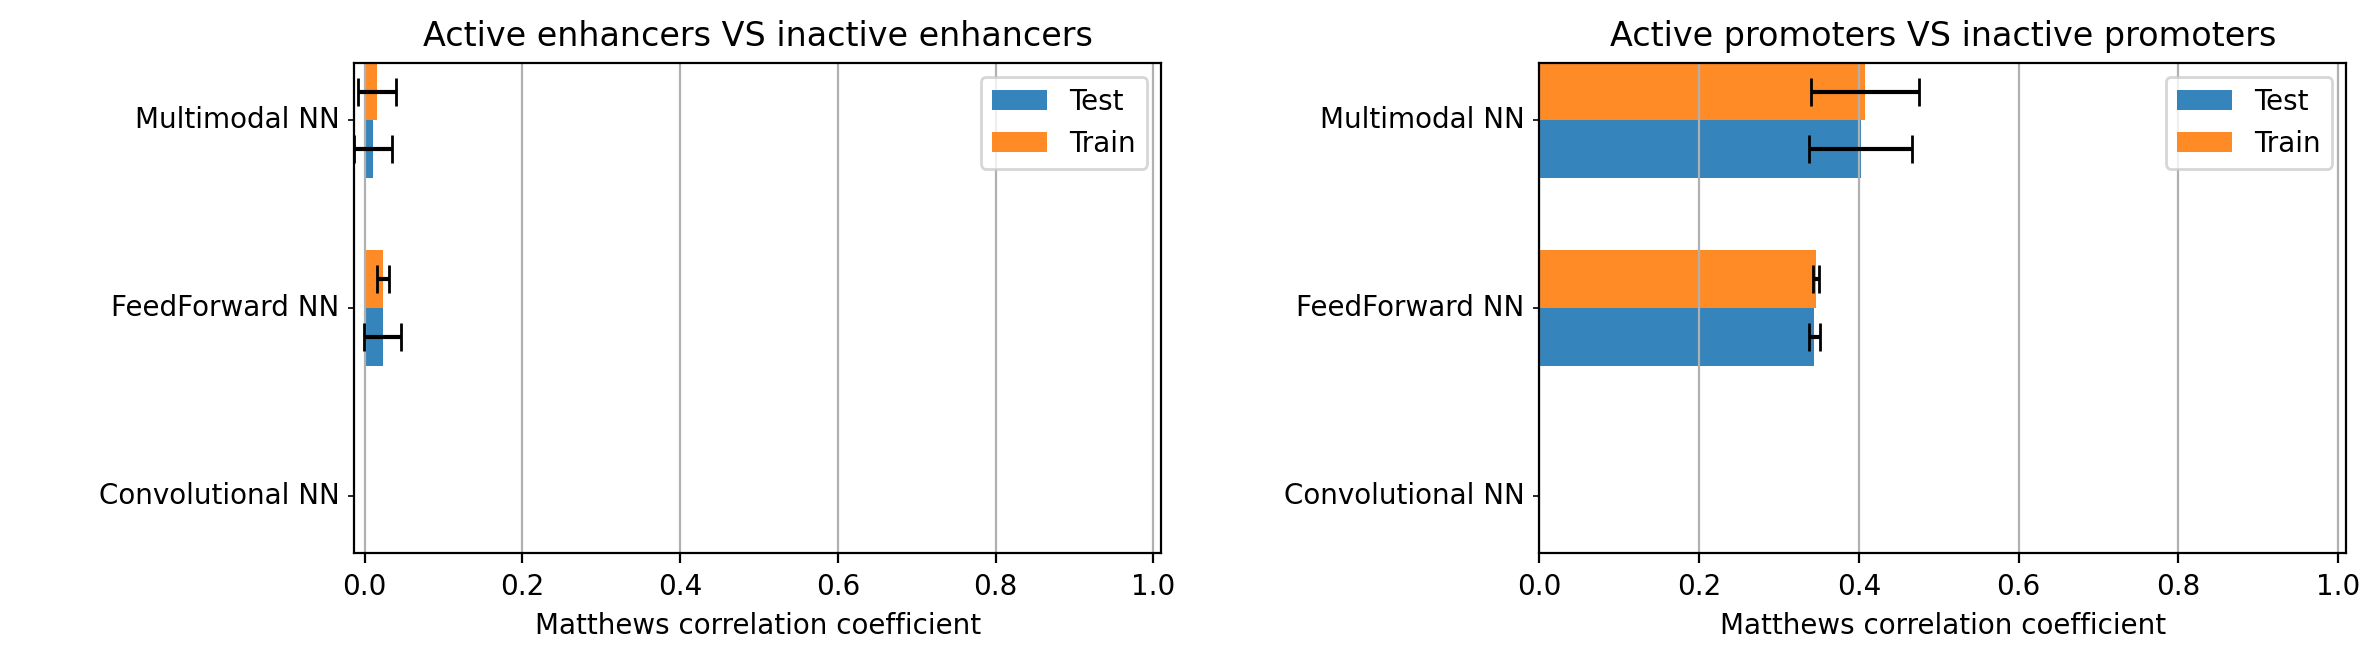

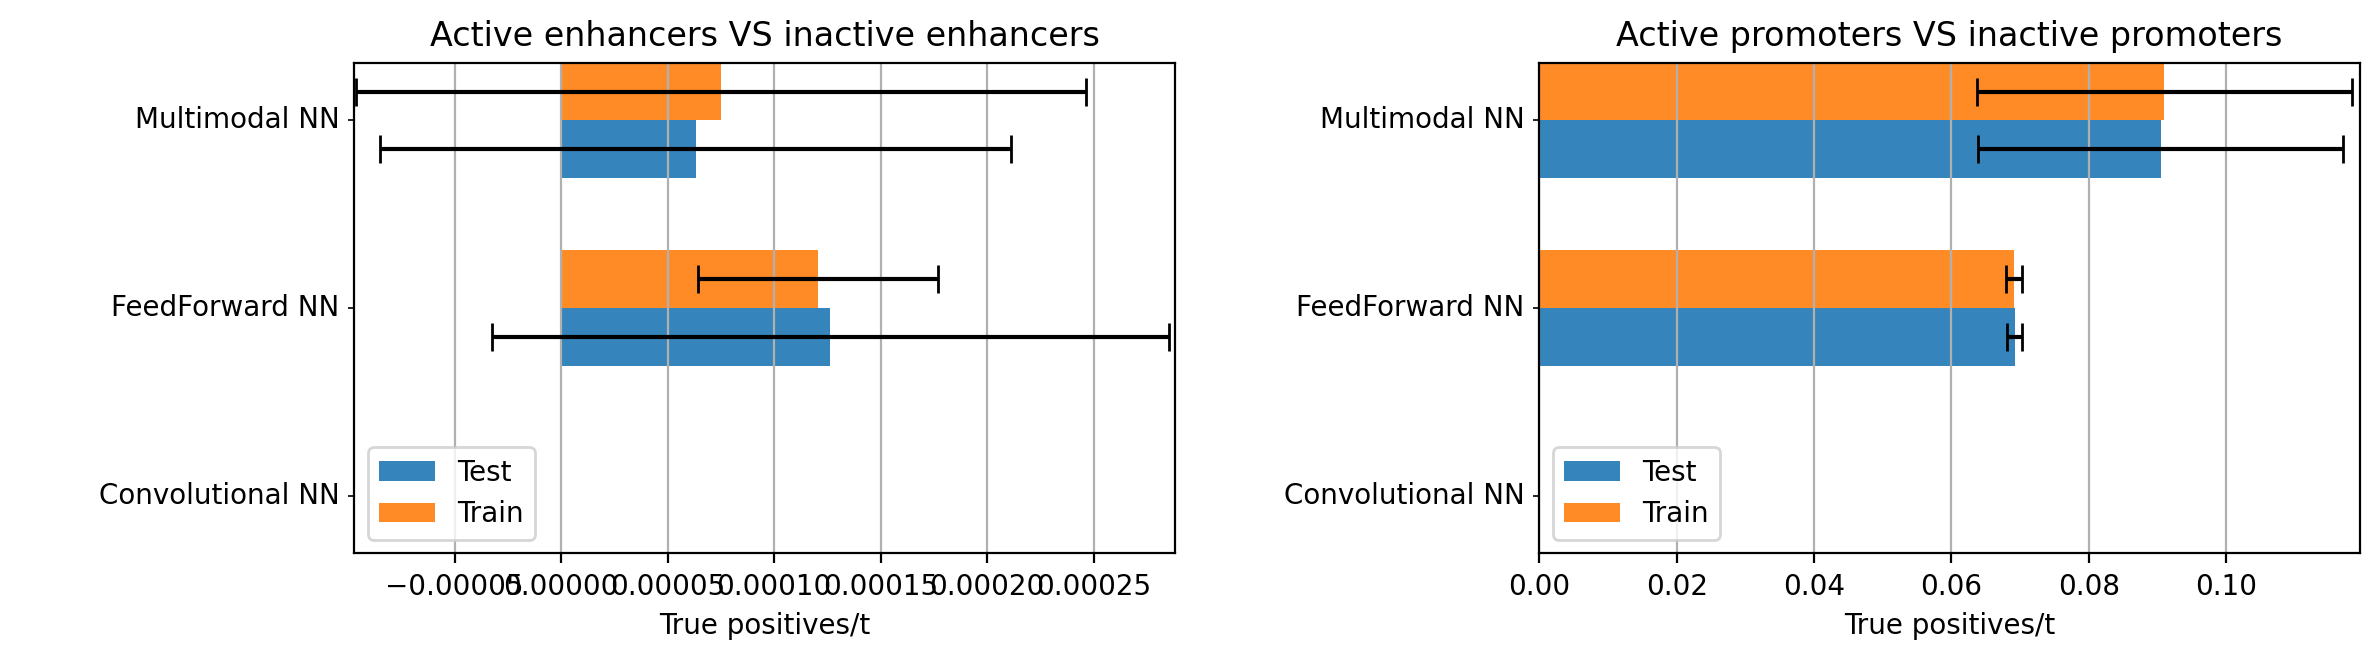

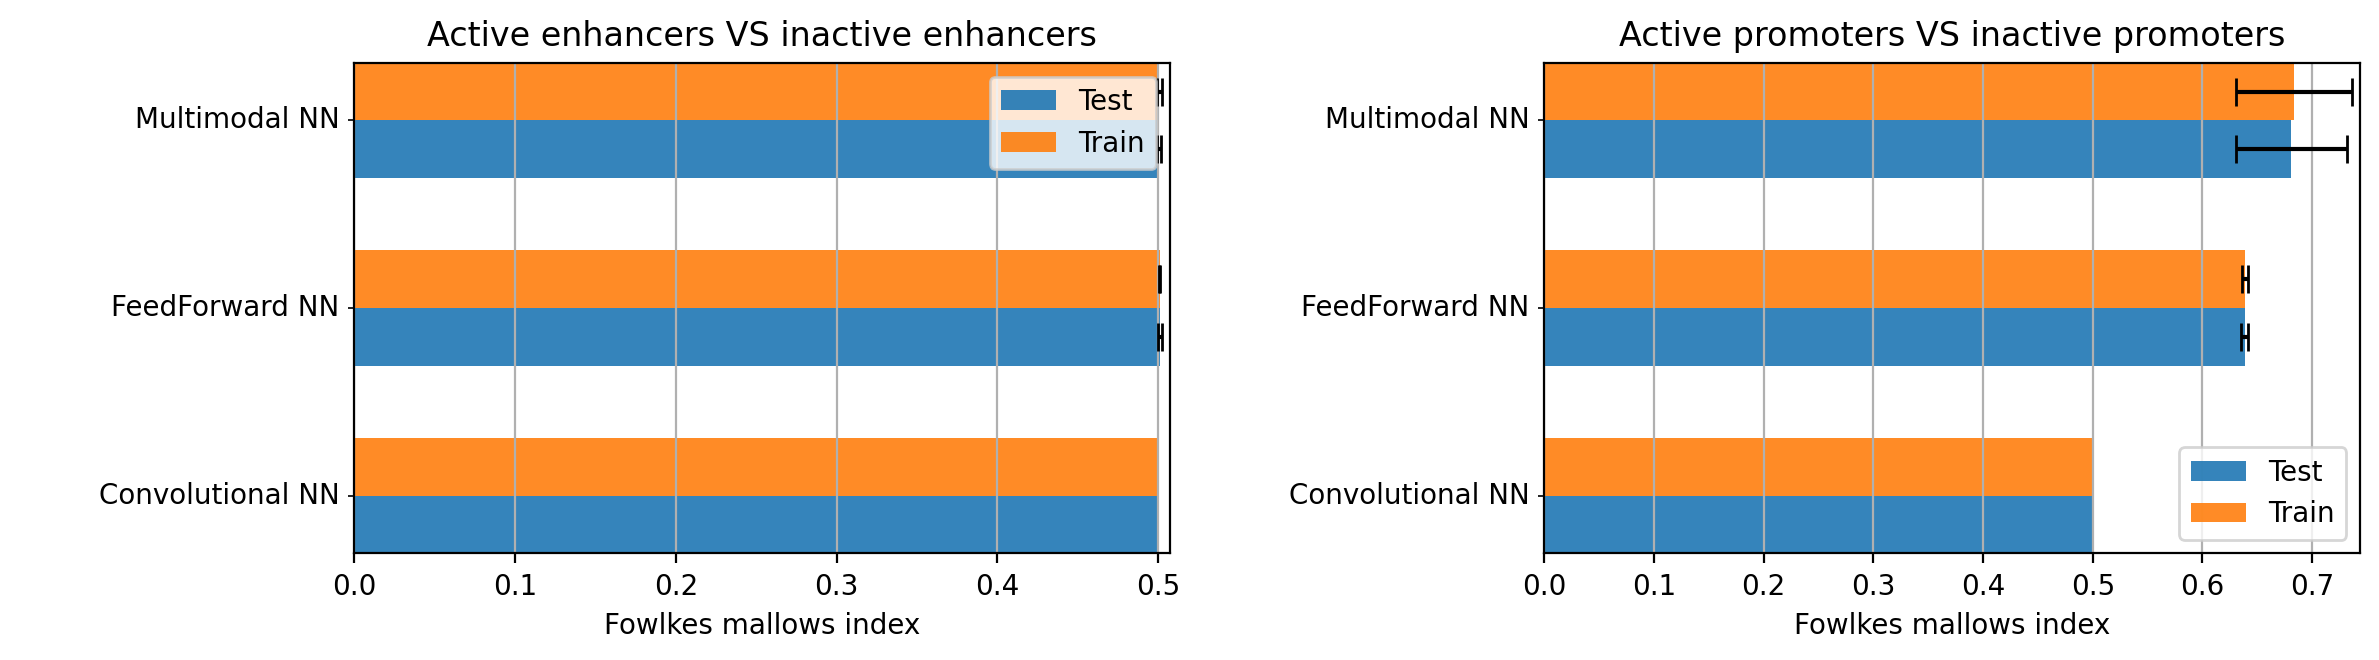

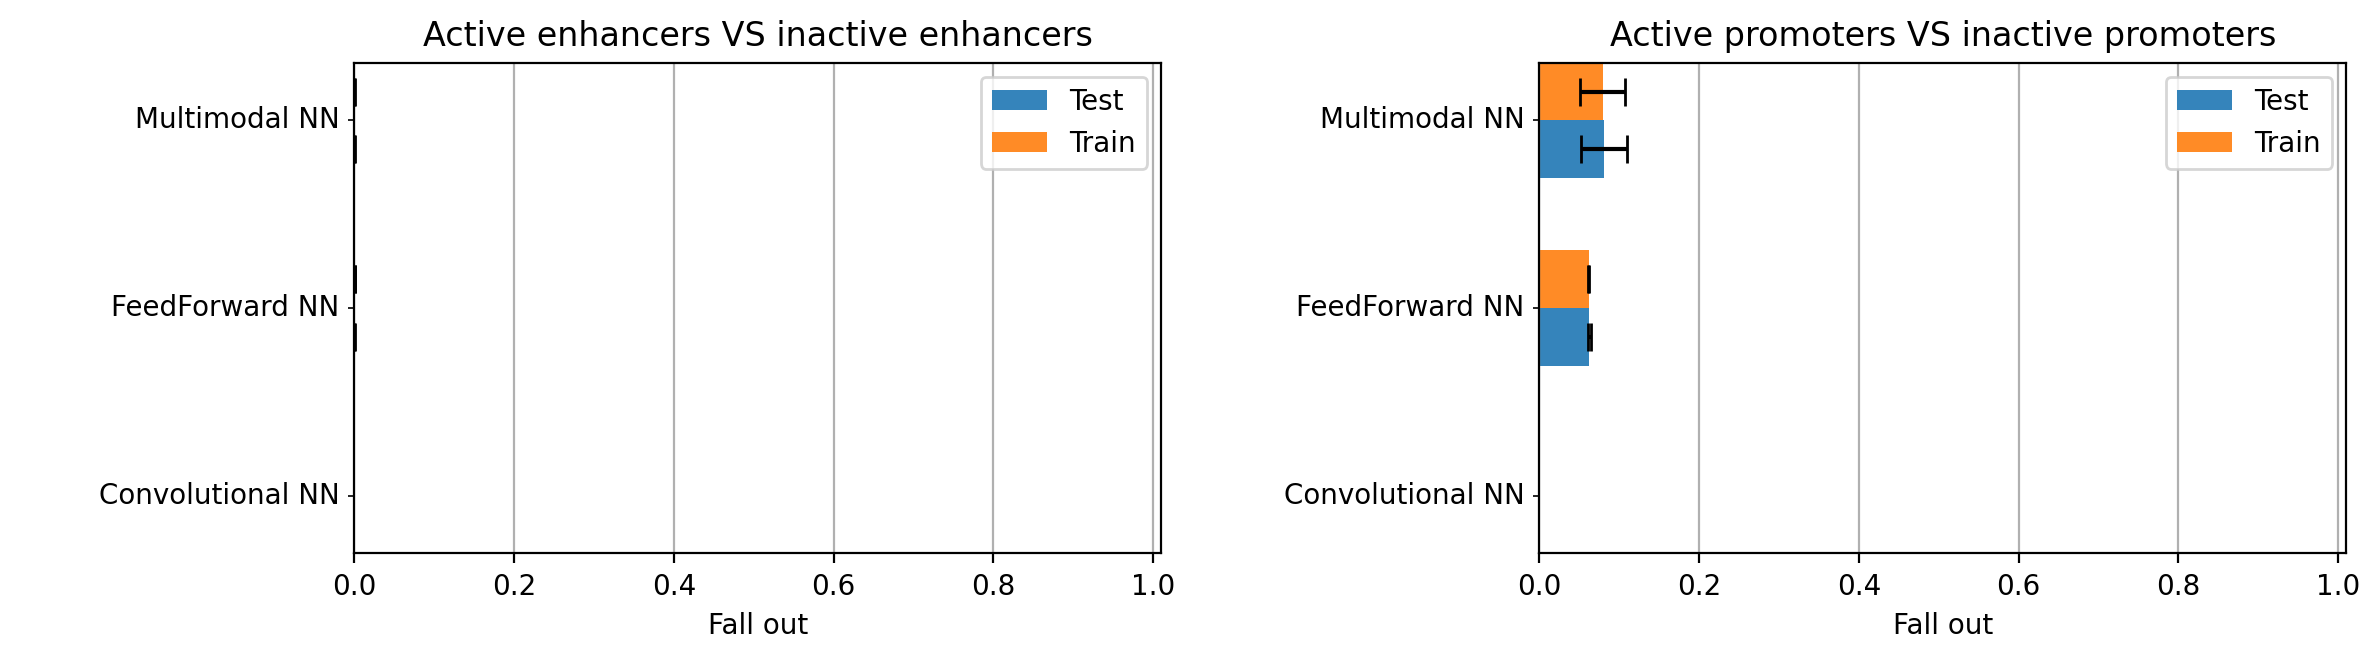

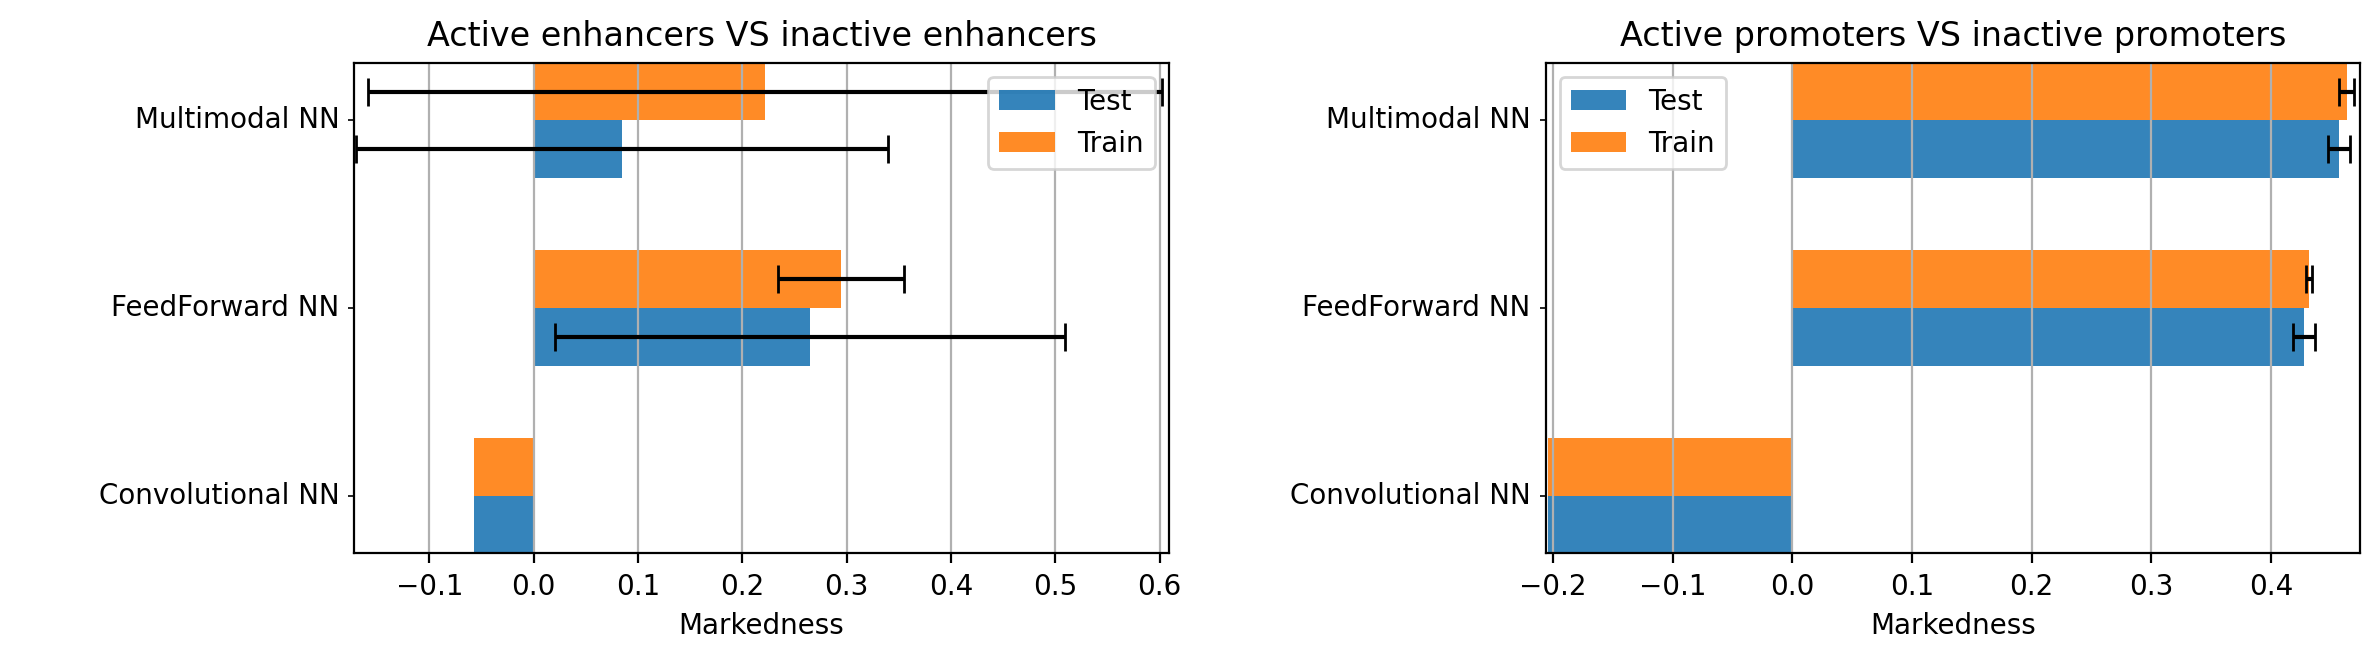

In [42]:
from barplots import barplots

barplots(
    all_binary_classification_performance.drop(columns=["holdout_number"]),
    groupby=["task", "model_name", "run_type"],
    orientation="horizontal",
    subplots=True,
    height=6,
    bar_width=0.4,
    space_width=0.5,
    use_multiprocessing=False
)

In [ ]:
data = all_binary_classification_performance[["model_name","task","run_type","loss","accuracy","AUROC","precision","recall"]]
data